In [40]:
"""
This script imports the necessary libraries for a comprehensive data processing, visualization, and video generation pipeline.
Libraries:
- pandas: Data manipulation and analysis.
- numpy: Numerical operations.
- seaborn: Statistical data visualization.
- sklearn.model_selection: Splitting data into training and testing sets.
- sklearn.preprocessing: Standardizing features.
- sklearn.linear_model: Implementing linear regression models.
- sklearn.metrics: Evaluating model performance.
- pandas.read_csv, pandas.read_excel: Reading data from CSV and Excel files.
- scipy.stats: Statistical functions.
- moviepy.editor: Video editing and creation.
- gtts: Text-to-speech conversion.
- matplotlib.pyplot: Plotting graphs and charts.
"""
# Loading all The necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas import read_csv, read_excel
from scipy import stats
from moviepy.editor import VideoClip, concatenate_videoclips
from gtts import gTTS
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
from matplotlib.animation import FuncAnimation
from scipy.signal import savgol_filter
from time import perf_counter
import math
# from config_loader import load_config_ani, load_config_setup
import matplotlib.pyplot as plt
import os
import pickle
import gtts
import requests
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForTokenClassification
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import uuid
from transformers import pipeline, T5ForConditionalGeneration, T5TokenizerFast
import re
import os
import uuid
import gtts
from textblob import TextBlob
from langdetect import detect
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas import read_csv, read_excel
from scipy import stats
from moviepy.editor import VideoClip, concatenate_videoclips, VideoFileClip, AudioFileClip, ImageSequenceClip
from gtts import gTTS
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import os
import pickle
import requests
import time
import json
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForTokenClassification
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import uuid

In [41]:
# Set the HF_HOME environment variable to change the cache path
os.environ['HF_HOME'] = "D:\\cahc_models_folder"  # Change this to your desired cache path

# Load the model and tokenizer from .pkl files
models_dir = os.path.abspath(os.path.join(os.getcwd(), 'models'))

with open(os.path.join(models_dir, 'model.pkl'), 'rb') as model_file:
    summary_model = pickle.load(model_file)

with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    summary_tokenizer = pickle.load(tokenizer_file)


In [42]:


# Install the vaderSentiment package
# %pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the model and tokenizer
# summary_model = T5ForConditionalGeneration.from_pretrained('t5-base')
# summary_tokenizer = T5TokenizerFast.from_pretrained('t5-base')

# Initialize sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# NLP Pipeline Function
def nlp_pipeline(text):
    # Prepare input
    input_text = f"summarize: {text}"
    inputs = summary_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Generate summary
    outputs = summary_model.generate(inputs, max_length=100)
    summary_text = summary_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract percentages and categories using regex patterns
    percentages = [int(x.strip('%')) for x in re.findall(r'\d+%', text)]
    words = text.split()
    categories = []

    # Find words after "use" or "uses"
    for i, word in enumerate(words):
        if word.lower() in ['use', 'uses'] and i + 1 < len(words):
            categories.append(words[i + 1])

    if not percentages or not categories:
        percentages = [100]
        categories = ['Summary']

    # Sentiment analysis
    sentiment = vader_analyzer.polarity_scores(summary_text)
    sentiment_label = 'positive' if sentiment['compound'] >= 0.05 else 'negative' if sentiment['compound'] <= -0.05 else 'neutral'

    # Text correction and language detection
    blob = TextBlob(summary_text)
    corrected_text = str(blob.correct())
    language = detect(corrected_text)  # Use langdetect to detect language

    # Generate audio
    tts = gtts.gTTS(corrected_text, lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)

    return {
        'categories': categories,
        'values': percentages,
        'text': corrected_text,
        'audio_path': audio_path,
        'sentiment': sentiment_label,
        'language': language
    }

# Example usage
if __name__ == "__main__":
    text = "20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands"
    summary = nlp_pipeline(text)
    print(summary)

{'categories': ['Summary'], 'values': [100], 'text': '20% of users own an shone, 50% own a Samsung, and the rest own a variety of bands . the rest own a variety of bands, including a to, a pp, a pp, a pp, a pp, a pp, a pp, a pp, a pp, a pp, a pp', 'audio_path': 'D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files\\summary_audio_5b04603bb63f41a2888800a340d41571.mp3', 'sentiment': 'neutral', 'language': 'en'}


In [10]:
# Define a function to generate infographics from custom prompt
def generate_infographics_from_prompt(prompt):
    # Use the NLP pipeline to process the prompt
    summary = nlp_pipeline(prompt)

    # Create a detailed infographic
    create_detailed_infographic(summary)

    # Generate animated GIF
    gif_path = create_animated_gif(summary)

    # Convert GIF to storytelling video
    final_video_path = convert_gif_to_storytelling_video(gif_path, summary)

    return final_video_path
    # Example usage
    if __name__ == "__main__":
        # Example text input
        text = "20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands"
        
        # Generate infographics from the text prompt
        final_video_path = generate_infographics_from_prompt(text)
        
        # Print the path to the final video
        print(f"Final video created at: {final_video_path}")

In [31]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# def create_detailed_infographic(summary):
#     """
#     Creates a static detailed infographic for data storytelling
#     """
#     categories = summary['categories']
#     values = summary['values']
#     sentiment = summary.get('sentiment', 'neutral')
#     language = summary.get('language', 'en')

#     # Create figure with subplots
#     fig = plt.figure(figsize=(18, 48))  # Increase the figure size to accommodate more subplots

#     # Main bar plot
#     ax1 = plt.subplot2grid((13, 2), (0, 0), colspan=2)  # Increase the grid size to (13, 2)
#     bars = ax1.bar(categories, values, color='skyblue', edgecolor='black')
#     ax1.set_title('Market Share Distribution', fontsize=20, pad=20)
#     ax1.set_ylabel('Percentage (%)', fontsize=14)
#     ax1.set_xlabel('Categories', fontsize=14)

#     # Add value labels
#     for bar in bars:
#         height = bar.get_height()
#         ax1.text(bar.get_x() + bar.get_width() / 2., height,
#                  f'{int(height)}%',
#                  ha='center', va='bottom', fontsize=12, color='black')

#     # Pie chart
#     ax2 = plt.subplot2grid((13, 2), (1, 0))
#     wedges, texts, autotexts = ax2.pie(values, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
#     for text in texts + autotexts:
#         text.set_fontsize(12)
#     ax2.set_title('Market Share Proportion', fontsize=16)

#     # Additional insights text
#     ax3 = plt.subplot2grid((13, 2), (1, 1))
#     ax3.axis('off')
#     total = sum(values)
#     insights_text = f"""Key Insights:

#     • Total market coverage: {total}%
#     • Leading brand: {categories[values.index(max(values))]}
#     • Market share gap: {max(values) - min(values)}%
#     • Sentiment: {sentiment.capitalize()}
#     • Language: {language.upper()}
#     """
#     ax3.text(0, 0.5, insights_text, fontsize=14, va='center', ha='left')

#     # Line plot
#     ax4 = plt.subplot2grid((13, 2), (2, 0), colspan=2)
#     ax4.plot(categories, values, marker='o', linestyle='-', color='b')
#     ax4.set_title('Market Share Trend', fontsize=16)
#     ax4.set_ylabel('Percentage (%)', fontsize=14)
#     ax4.set_xlabel('Categories', fontsize=14)
#     for i, value in enumerate(values):
#         ax4.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

#     # Scatter plot
#     ax5 = plt.subplot2grid((13, 2), (3, 0))
#     ax5.scatter(categories, values, color='r')
#     ax5.set_title('Market Share Scatter Plot', fontsize=16)
#     ax5.set_ylabel('Percentage (%)', fontsize=14)
#     ax5.set_xlabel('Categories', fontsize=14)
#     for i, value in enumerate(values):
#         ax5.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

#     # Box plot
#     ax6 = plt.subplot2grid((13, 2), (3, 1))
#     ax6.boxplot(values, vert=False, patch_artist=True)
#     ax6.set_title('Market Share Box Plot', fontsize=16)
#     ax6.set_xlabel('Percentage (%)', fontsize=14)
#     ax6.set_yticklabels(['Market Share'])

#     # Histogram
#     ax7 = plt.subplot2grid((13, 2), (4, 0))
#     ax7.hist(values, bins=10, color='purple', edgecolor='black')
#     ax7.set_title('Market Share Histogram', fontsize=16)
#     ax7.set_xlabel('Percentage (%)', fontsize=14)
#     ax7.set_ylabel('Frequency', fontsize=14)

#     # Heatmap
#     ax8 = plt.subplot2grid((13, 2), (4, 1))
#     heatmap_data = np.array(values).reshape(-1, 1)
#     sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='coolwarm', ax=ax8)
#     ax8.set_title('Market Share Heatmap', fontsize=16)

#     # Violin plot
#     ax9 = plt.subplot2grid((13, 2), (5, 0))
#     sns.violinplot(data=values, ax=ax9)
#     ax9.set_title('Market Share Violin Plot', fontsize=16)
#     ax9.set_xlabel('Market Share', fontsize=14)

#     # Pair plot
#     ax10 = plt.subplot2grid((13, 2), (5, 1))
#     sns.pairplot(pd.DataFrame({'Categories': categories, 'Values': values}), ax=ax10)
#     ax10.set_title('Market Share Pair Plot', fontsize=16)

#     # KDE plot
#     ax11 = plt.subplot2grid((13, 2), (6, 0))
#     sns.kdeplot(values, ax=ax11, shade=True, color='green')
#     ax11.set_title('Market Share KDE Plot', fontsize=16)
#     ax11.set_xlabel('Percentage (%)', fontsize=14)

#     # Joint plot
#     ax12 = plt.subplot2grid((13, 2), (6, 1))
#     sns.jointplot(x=categories, y=values, kind='scatter', ax=ax12)
#     ax12.set_title('Market Share Joint Plot', fontsize=16)

#     # Swarm plot
#     ax13 = plt.subplot2grid((13, 2), (7, 0))
#     sns.swarmplot(x=categories, y=values, ax=ax13)
#     ax13.set_title('Market Share Swarm Plot', fontsize=16)
#     ax13.set_xlabel('Categories', fontsize=14)
#     ax13.set_ylabel('Percentage (%)', fontsize=14)

#     # Strip plot
#     ax14 = plt.subplot2grid((13, 2), (7, 1))
#     sns.stripplot(x=categories, y=values, ax=ax14)
#     ax14.set_title('Market Share Strip Plot', fontsize=16)
#     ax14.set_xlabel('Categories', fontsize=14)
#     ax14.set_ylabel('Percentage (%)', fontsize=14)

#     # Rug plot
#     ax15 = plt.subplot2grid((13, 2), (8, 0))
#     sns.rugplot(values, ax=ax15)
#     ax15.set_title('Market Share Rug Plot', fontsize=16)
#     ax15.set_xlabel('Percentage (%)', fontsize=14)

#     # Count plot
#     ax16 = plt.subplot2grid((13, 2), (8, 1))
#     sns.countplot(x=categories, ax=ax16)
#     ax16.set_title('Market Share Count Plot', fontsize=16)
#     ax16.set_xlabel('Categories', fontsize=14)
#     ax16.set_ylabel('Count', fontsize=14)

#     # Boxen plot
#     ax17 = plt.subplot2grid((13, 2), (9, 0))
#     sns.boxenplot(x=categories, y=values, ax=ax17)
#     ax17.set_title('Market Share Boxen Plot', fontsize=16)
#     ax17.set_xlabel('Categories', fontsize=14)
#     ax17.set_ylabel('Percentage (%)', fontsize=14)

#     # Point plot
#     ax18 = plt.subplot2grid((13, 2), (9, 1))
#     sns.pointplot(x=categories, y=values, ax=ax18)
#     ax18.set_title('Market Share Point Plot', fontsize=16)
#     ax18.set_xlabel('Categories', fontsize=14)
#     ax18.set_ylabel('Percentage (%)', fontsize=14)

#     # Residual plot
#     ax19 = plt.subplot2grid((13, 2), (10, 0))
#     sns.residplot(x=categories, y=values, ax=ax19)
#     ax19.set_title('Market Share Residual Plot', fontsize=16)
#     ax19.set_xlabel('Categories', fontsize=14)
#     ax19.set_ylabel('Residuals', fontsize=14)

#     # Lm plot
#     ax20 = plt.subplot2grid((13, 2), (10, 1))
#     sns.lmplot(x='Categories', y='Values', data=pd.DataFrame({'Categories': categories, 'Values': values}), ax=ax20)
#     ax20.set_title('Market Share Lm Plot', fontsize=16)

#     # PairGrid
#     ax21 = plt.subplot2grid((13, 2), (11, 0))
#     pairgrid = sns.PairGrid(pd.DataFrame({'Categories': categories, 'Values': values}))
#     pairgrid.map(plt.scatter)
#     ax21.set_title('Market Share PairGrid', fontsize=16)

#     # FacetGrid
#     ax22 = plt.subplot2grid((13, 2), (11, 1))
#     facetgrid = sns.FacetGrid(pd.DataFrame({'Categories': categories, 'Values': values}), col='Categories')
#     facetgrid.map(plt.hist, 'Values')
#     ax22.set_title('Market Share FacetGrid', fontsize=16)

#     # Heatmap with annotations
#     ax23 = plt.subplot2grid((13, 2), (12, 0))
#     sns.heatmap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm', ax=ax23)
#     ax23.set_title('Market Share Heatmap with Annotations', fontsize=16)

#     # Clustermap
#     ax24 = plt.subplot2grid((13, 2), (12, 1))
#     sns.clustermap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm')
#     ax24.set_title('Market Share Clustermap', fontsize=16)

#     plt.tight_layout()
#     # Save high-quality image
#     output_path = 'detailed_infographic.png'
#     plt.savefig(output_path, dpi=300, bbox_inches='tight')
#     plt.close()

#     print(f"Detailed infographic saved as: {output_path}")
#     return output_path

# # Example usage
# if __name__ == "__main__":
#     summary = {
#         'categories': ['iPhone', 'Samsung', 'Others'],
#         'values': [20, 50, 30],
#         'text': '20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands',
#         'audio_path': 'D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files\\summary_audio.mp3',
#         'sentiment': 'neutral',
#         'language': 'en'
#     }
#     create_detailed_infographic(summary)

In [44]:
def create_animated_gif(summary):
    categories = summary['categories']
    values = summary['values']

    # Create a unique frames directory
    frames_dir = f'animation_frames_{uuid.uuid4().hex}'
    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)  # Remove directory if it exists
    os.makedirs(frames_dir)

    def create_frame(frame_number, value_multiplier, categories=categories, values=values):
        fig, ax = plt.subplots(figsize=(12, 7))

        # Calculate current height of bars
        current_values = [v * value_multiplier for v in values]

        # Create bars with current height
        bars = ax.bar(categories, current_values, color='skyblue')

        # Styling
        ax.set_title('Market Share Analysis', fontsize=20, pad=20)
        ax.set_xlabel('Brands', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.set_ylim(0, max(values) * 1.2)

        # Add value labels
        for bar, value in zip(bars, current_values):
            if value > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                       f'{int(value)}%',
                       ha='center', va='bottom', fontsize=12)

        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save frame
        frame_path = os.path.join(frames_dir, f'frame_{frame_number:03d}.png')
        plt.savefig(frame_path, dpi=300, bbox_inches='tight')
        plt.close()
        return frame_path

    # Generate frames
    frames = []
    num_frames = 20  # Number of frames for animation

    print("Generating frames...")
    for i in range(num_frames + 1):
        multiplier = i / num_frames
        frame_path = create_frame(i, multiplier)
        frames.append(frame_path)

    # Create GIF
    print("Creating GIF...")
    images = [Image.open(f) for f in frames]

    gif_path = 'animated_infographic.gif'
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=100,  # 100ms between frames
        loop=0
    )

    # Clean up frames directory
    try:
        shutil.rmtree(frames_dir)
        print("Cleanup completed successfully")
    except Exception as e:
        print(f"Cleanup error: {e}")

    print(f"Animation saved as GIF: {gif_path}")
    return gif_path

In [ ]:
def create_detailed_infographic(summary):
    categories = summary['categories']
    values = summary['values']

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # Main bar plot
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    bars = ax1.bar(categories, values, color='skyblue')
    ax1.set_title('Market Share Distribution', fontsize=16)
    ax1.set_ylabel('Percentage (%)')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}%',
                ha='center', va='bottom')

    # Pie chart
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.pie(values, labels=categories, autopct='%1.1f%%')
    ax2.set_title('Market Share Proportion')

    # Additional insights text
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax3.axis('off')
    total = sum(values)
    insights_text = f"""Key Insights:

    • Total market coverage: {total}%
    • Leading brand: {categories[values.index(max(values))]}
    • Market share gap: {max(values) - min(values)}%
    """
    ax3.text(0, 0.5, insights_text, fontsize=12, va='center')

    plt.tight_layout()

    # Save high-quality image
    output_path = 'detailed_infographic.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Detailed infographic saved as: {output_path}")
    return output_path

In [34]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# def create_detailed_infographic(summary):
#     """
#     Creates a static detailed infographic for data storytelling
#     """
#     categories = summary['categories']
#     values = summary['values']
#     sentiment = summary.get('sentiment', 'neutral')
#     language = summary.get('language', 'en')

#     # Create figure with subplots
#     fig = plt.figure(figsize=(18, 48))  # Increase the figure size to accommodate more subplots

#     # Main bar plot
#     ax1 = plt.subplot2grid((13, 2), (0, 0), colspan=2)  # Increase the grid size to (13, 2)
#     bars = ax1.bar(categories, values, color='skyblue', edgecolor='black')
#     ax1.set_title('Market Share Distribution', fontsize=20, pad=20)
#     ax1.set_ylabel('Percentage (%)', fontsize=14)
#     ax1.set_xlabel('Categories', fontsize=14)

#     # Add value labels
#     for bar in bars:
#         height = bar.get_height()
#         ax1.text(bar.get_x() + bar.get_width() / 2., height,
#                  f'{int(height)}%',
#                  ha='center', va='bottom', fontsize=12, color='black')

#     # Pie chart
#     ax2 = plt.subplot2grid((13, 2), (1, 0))
#     wedges, texts, autotexts = ax2.pie(values, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
#     for text in texts + autotexts:
#         text.set_fontsize(12)
#     ax2.set_title('Market Share Proportion', fontsize=16)

#     # Additional insights text
#     ax3 = plt.subplot2grid((13, 2), (1, 1))
#     ax3.axis('off')
#     total = sum(values)
#     insights_text = f"""Key Insights:

#     • Total market coverage: {total}%
#     • Leading brand: {categories[values.index(max(values))]}
#     • Market share gap: {max(values) - min(values)}%
#     • Sentiment: {sentiment.capitalize()}
#     • Language: {language.upper()}
#     """
#     ax3.text(0, 0.5, insights_text, fontsize=14, va='center', ha='left')

#     # Line plot
#     ax4 = plt.subplot2grid((13, 2), (2, 0), colspan=2)
#     ax4.plot(categories, values, marker='o', linestyle='-', color='b')
#     ax4.set_title('Market Share Trend', fontsize=16)
#     ax4.set_ylabel('Percentage (%)', fontsize=14)
#     ax4.set_xlabel('Categories', fontsize=14)
#     for i, value in enumerate(values):
#         ax4.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

#     # Scatter plot
#     ax5 = plt.subplot2grid((13, 2), (3, 0))
#     ax5.scatter(categories, values, color='r')
#     ax5.set_title('Market Share Scatter Plot', fontsize=16)
#     ax5.set_ylabel('Percentage (%)', fontsize=14)
#     ax5.set_xlabel('Categories', fontsize=14)
#     for i, value in enumerate(values):
#         ax5.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

#     # Box plot
#     ax6 = plt.subplot2grid((13, 2), (3, 1))
#     ax6.boxplot(values, vert=False, patch_artist=True)
#     ax6.set_title('Market Share Box Plot', fontsize=16)
#     ax6.set_xlabel('Percentage (%)', fontsize=14)
#     ax6.set_yticklabels(['Market Share'])

#     # Histogram
#     ax7 = plt.subplot2grid((13, 2), (4, 0))
#     ax7.hist(values, bins=10, color='purple', edgecolor='black')
#     ax7.set_title('Market Share Histogram', fontsize=16)
#     ax7.set_xlabel('Percentage (%)', fontsize=14)
#     ax7.set_ylabel('Frequency', fontsize=14)

#     # Heatmap
#     ax8 = plt.subplot2grid((13, 2), (4, 1))
#     heatmap_data = np.array(values).reshape(-1, 1)
#     sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='coolwarm', ax=ax8)
#     ax8.set_title('Market Share Heatmap', fontsize=16)

#     # Violin plot
#     ax9 = plt.subplot2grid((13, 2), (5, 0))
#     sns.violinplot(data=values, ax=ax9)
#     ax9.set_title('Market Share Violin Plot', fontsize=16)
#     ax9.set_xlabel('Market Share', fontsize=14)

#     # Pair plot
#     ax10 = plt.subplot2grid((13, 2), (5, 1))
#     sns.pairplot(pd.DataFrame({'Categories': categories, 'Values': values}), ax=ax10)
#     ax10.set_title('Market Share Pair Plot', fontsize=16)

#     # KDE plot
#     ax11 = plt.subplot2grid((13, 2), (6, 0))
#     sns.kdeplot(values, ax=ax11, shade=True, color='green')
#     ax11.set_title('Market Share KDE Plot', fontsize=16)
#     ax11.set_xlabel('Percentage (%)', fontsize=14)

#     # Joint plot
#     ax12 = plt.subplot2grid((13, 2), (6, 1))
#     sns.jointplot(x=categories, y=values, kind='scatter', ax=ax12)
#     ax12.set_title('Market Share Joint Plot', fontsize=16)

#     # Swarm plot
#     ax13 = plt.subplot2grid((13, 2), (7, 0))
#     sns.swarmplot(x=categories, y=values, ax=ax13)
#     ax13.set_title('Market Share Swarm Plot', fontsize=16)
#     ax13.set_xlabel('Categories', fontsize=14)
#     ax13.set_ylabel('Percentage (%)', fontsize=14)

#     # Strip plot
#     ax14 = plt.subplot2grid((13, 2), (7, 1))
#     sns.stripplot(x=categories, y=values, ax=ax14)
#     ax14.set_title('Market Share Strip Plot', fontsize=16)
#     ax14.set_xlabel('Categories', fontsize=14)
#     ax14.set_ylabel('Percentage (%)', fontsize=14)

#     # Rug plot
#     ax15 = plt.subplot2grid((13, 2), (8, 0))
#     sns.rugplot(values, ax=ax15)
#     ax15.set_title('Market Share Rug Plot', fontsize=16)
#     ax15.set_xlabel('Percentage (%)', fontsize=14)

#     # Count plot
#     ax16 = plt.subplot2grid((13, 2), (8, 1))
#     sns.countplot(x=categories, ax=ax16)
#     ax16.set_title('Market Share Count Plot', fontsize=16)
#     ax16.set_xlabel('Categories', fontsize=14)
#     ax16.set_ylabel('Count', fontsize=14)

#     # Boxen plot
#     ax17 = plt.subplot2grid((13, 2), (9, 0))
#     sns.boxenplot(x=categories, y=values, ax=ax17)
#     ax17.set_title('Market Share Boxen Plot', fontsize=16)
#     ax17.set_xlabel('Categories', fontsize=14)
#     ax17.set_ylabel('Percentage (%)', fontsize=14)

#     # Point plot
#     ax18 = plt.subplot2grid((13, 2), (9, 1))
#     sns.pointplot(x=categories, y=values, ax=ax18)
#     ax18.set_title('Market Share Point Plot', fontsize=16)
#     ax18.set_xlabel('Categories', fontsize=14)
#     ax18.set_ylabel('Percentage (%)', fontsize=14)

#     # Residual plot
#     ax19 = plt.subplot2grid((13, 2), (10, 0))
#     sns.residplot(x=categories, y=values, ax=ax19)
#     ax19.set_title('Market Share Residual Plot', fontsize=16)
#     ax19.set_xlabel('Categories', fontsize=14)
#     ax19.set_ylabel('Residuals', fontsize=14)

#     # Lm plot
#     ax20 = plt.subplot2grid((13, 2), (10, 1))
#     sns.lmplot(x='Categories', y='Values', data=pd.DataFrame({'Categories': categories, 'Values': values}), ax=ax20)
#     ax20.set_title('Market Share Lm Plot', fontsize=16)

#     # PairGrid
#     ax21 = plt.subplot2grid((13, 2), (11, 0))
#     pairgrid = sns.PairGrid(pd.DataFrame({'Categories': categories, 'Values': values}))
#     pairgrid.map(plt.scatter)
#     ax21.set_title('Market Share PairGrid', fontsize=16)

#     # FacetGrid
#     ax22 = plt.subplot2grid((13, 2), (11, 1))
#     facetgrid = sns.FacetGrid(pd.DataFrame({'Categories': categories, 'Values': values}), col='Categories')
#     facetgrid.map(plt.hist, 'Values')
#     ax22.set_title('Market Share FacetGrid', fontsize=16)

#     # Heatmap with annotations
#     ax23 = plt.subplot2grid((13, 2), (12, 0))
#     sns.heatmap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm', ax=ax23)
#     ax23.set_title('Market Share Heatmap with Annotations', fontsize=16)

#     # Clustermap
#     ax24 = plt.subplot2grid((13, 2), (12, 1))
#     sns.clustermap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm')
#     ax24.set_title('Market Share Clustermap', fontsize=16)

#     plt.tight_layout()
#     # Save high-quality image
#     output_path = 'detailed_infographic.png'
#     plt.savefig(output_path, dpi=300, bbox_inches='tight')
#     plt.close()

#     print(f"Detailed infographic saved as: {output_path}")
#     return output_path

# # Example usage
# if __name__ == "__main__":
#     summary = {
#         'categories': ['iPhone', 'Samsung', 'Others'],
#         'values': [20, 50, 30],
#         'text': '20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands',
#         'audio_path': 'D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files\\summary_audio.mp3',
#         'sentiment': 'neutral',
#         'language': 'en'
#     }
#     create_detailed_infographic(summary)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_detailed_infographic(summary):
    """
    Creates a static detailed infographic for data storytelling
    """
    categories = summary['categories']
    values = summary['values']
    sentiment = summary.get('sentiment', 'neutral')
    language = summary.get('language', 'en')

    # Create figure with subplots
    fig = plt.figure(figsize=(18, 48))  # Increase the figure size to accommodate more subplots

    # Main bar plot
    ax1 = plt.subplot2grid((13, 2), (0, 0), colspan=2)  # Increase the grid size to (13, 2)
    bars = ax1.bar(categories, values, color='skyblue', edgecolor='black')
    ax1.set_title('Market Share Distribution', fontsize=20, pad=20)
    ax1.set_ylabel('Percentage (%)', fontsize=14)
    ax1.set_xlabel('Categories', fontsize=14)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{int(height)}%',
                 ha='center', va='bottom', fontsize=12, color='black')

    # Pie chart
    ax2 = plt.subplot2grid((13, 2), (1, 0))
    wedges, texts, autotexts = ax2.pie(values, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    for text in texts + autotexts:
        text.set_fontsize(12)
    ax2.set_title('Market Share Proportion', fontsize=16)

    # Additional insights text
    ax3 = plt.subplot2grid((13, 2), (1, 1))
    ax3.axis('off')
    total = sum(values)
    insights_text = f"""Key Insights:

    • Total market coverage: {total}%
    • Leading brand: {categories[values.index(max(values))]}
    • Market share gap: {max(values) - min(values)}%
    • Sentiment: {sentiment.capitalize()}
    • Language: {language.upper()}
    """
    ax3.text(0, 0.5, insights_text, fontsize=14, va='center', ha='left')

    # Line plot
    ax4 = plt.subplot2grid((13, 2), (2, 0), colspan=2)
    ax4.plot(categories, values, marker='o', linestyle='-', color='b')
    ax4.set_title('Market Share Trend', fontsize=16)
    ax4.set_ylabel('Percentage (%)', fontsize=14)
    ax4.set_xlabel('Categories', fontsize=14)
    for i, value in enumerate(values):
        ax4.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

    # Scatter plot
    ax5 = plt.subplot2grid((13, 2), (3, 0))
    ax5.scatter(categories, values, color='r')
    ax5.set_title('Market Share Scatter Plot', fontsize=16)
    ax5.set_ylabel('Percentage (%)', fontsize=14)
    ax5.set_xlabel('Categories', fontsize=14)
    for i, value in enumerate(values):
        ax5.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

    # Box plot
    ax6 = plt.subplot2grid((13, 2), (3, 1))
    ax6.boxplot(values, vert=False, patch_artist=True)
    ax6.set_title('Market Share Box Plot', fontsize=16)
    ax6.set_xlabel('Percentage (%)', fontsize=14)
    ax6.set_yticklabels(['Market Share'])

    # Histogram
    ax7 = plt.subplot2grid((13, 2), (4, 0))
    ax7.hist(values, bins=10, color='purple', edgecolor='black')
    ax7.set_title('Market Share Histogram', fontsize=16)
    ax7.set_xlabel('Percentage (%)', fontsize=14)
    ax7.set_ylabel('Frequency', fontsize=14)

    # Heatmap
    ax8 = plt.subplot2grid((13, 2), (4, 1))
    heatmap_data = np.array(values).reshape(-1, 1)
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='coolwarm', ax=ax8)
    ax8.set_title('Market Share Heatmap', fontsize=16)

    # Violin plot
    ax9 = plt.subplot2grid((13, 2), (5, 0))
    sns.violinplot(data=values, ax=ax9)
    ax9.set_title('Market Share Violin Plot', fontsize=16)
    ax9.set_xlabel('Market Share', fontsize=14)

    # Pair plot
    sns.pairplot(pd.DataFrame({'Categories': categories, 'Values': values}))
    plt.suptitle('Market Share Pair Plot', fontsize=16)

    # KDE plot
    ax11 = plt.subplot2grid((13, 2), (6, 0))
    sns.kdeplot(values, ax=ax11, shade=True, color='green')
    ax11.set_title('Market Share KDE Plot', fontsize=16)
    ax11.set_xlabel('Percentage (%)', fontsize=14)

    # Joint plot
    ax12 = plt.subplot2grid((13, 2), (6, 1))
    sns.jointplot(x=pd.Categorical(categories).codes, y=values, kind='scatter', ax=ax12)
    ax12.set_title('Market Share Joint Plot', fontsize=16)

    # Swarm plot
    ax13 = plt.subplot2grid((13, 2), (7, 0))
    sns.swarmplot(x=categories, y=values, ax=ax13)
    ax13.set_title('Market Share Swarm Plot', fontsize=16)
    ax13.set_xlabel('Categories', fontsize=14)
    ax13.set_ylabel('Percentage (%)', fontsize=14)

    # Strip plot
    ax14 = plt.subplot2grid((13, 2), (7, 1))
    sns.stripplot(x=categories, y=values, ax=ax14)
    ax14.set_title('Market Share Strip Plot', fontsize=16)
    ax14.set_xlabel('Categories', fontsize=14)
    ax14.set_ylabel('Percentage (%)', fontsize=14)

    # Rug plot
    ax15 = plt.subplot2grid((13, 2), (8, 0))
    sns.rugplot(values, ax=ax15)
    ax15.set_title('Market Share Rug Plot', fontsize=16)
    ax15.set_xlabel('Percentage (%)', fontsize=14)

    # Count plot
    ax16 = plt.subplot2grid((13, 2), (8, 1))
    sns.countplot(x=categories, ax=ax16)
    ax16.set_title('Market Share Count Plot', fontsize=16)
    ax16.set_xlabel('Categories', fontsize=14)
    ax16.set_ylabel('Count', fontsize=14)

    # Boxen plot
    ax17 = plt.subplot2grid((13, 2), (9, 0))
    sns.boxenplot(x=categories, y=values, ax=ax17)
    ax17.set_title('Market Share Boxen Plot', fontsize=16)
    ax17.set_xlabel('Categories', fontsize=14)
    ax17.set_ylabel('Percentage (%)', fontsize=14)

    # Point plot
    ax18 = plt.subplot2grid((13, 2), (9, 1))
    sns.pointplot(x=categories, y=values, ax=ax18)
    ax18.set_title('Market Share Point Plot', fontsize=16)
    ax18.set_xlabel('Categories', fontsize=14)
    ax18.set_ylabel('Percentage (%)', fontsize=14)

    # Residual plot
    ax19 = plt.subplot2grid((13, 2), (10, 0))
    sns.residplot(x=pd.Categorical(categories).codes, y=values, ax=ax19)
    ax19.set_title('Market Share Residual Plot', fontsize=16)
    ax19.set_xlabel('Categories', fontsize=14)
    ax19.set_ylabel('Residuals', fontsize=14)

    # Lm plot
    ax20 = plt.subplot2grid((13, 2), (10, 1))
    sns.lmplot(x='Categories', y='Values', data=pd.DataFrame({'Categories': pd.Categorical(categories).codes, 'Values': values}), ax=ax20)
    ax20.set_title('Market Share Lm Plot', fontsize=16)

    # PairGrid
    ax21 = plt.subplot2grid((13, 2), (11, 0))
    pairgrid = sns.PairGrid(pd.DataFrame({'Categories': categories, 'Values': values}))
    pairgrid.map(plt.scatter)
    ax21.set_title('Market Share PairGrid', fontsize=16)

    # FacetGrid
    ax22 = plt.subplot2grid((13, 2), (11, 1))
    facetgrid = sns.FacetGrid(pd.DataFrame({'Categories': categories, 'Values': values}), col='Categories')
    facetgrid.map(plt.hist, 'Values')
    ax22.set_title('Market Share FacetGrid', fontsize=16)

    # Heatmap with annotations
    ax23 = plt.subplot2grid((13, 2), (12, 0))
    sns.heatmap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm', ax=ax23)
    ax23.set_title('Market Share Heatmap with Annotations', fontsize=16)

    # Clustermap
    ax24 = plt.subplot2grid((13, 2), (12, 1))
    sns.clustermap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm')
    ax24.set_title('Market Share Clustermap', fontsize=16)

    plt.tight_layout()
    # Save high-quality image
    output_path = 'detailed_infographic.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Detailed infographic saved as: {output_path}")
    return output_path
# # Example usage
# if __name__ == "__main__":
#     summary = {
#         'categories': ['iPhone', 'Samsung', 'Others'],
#         'values': [20, 50, 30],
#         'text': '20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands',
#         'audio_path': 'D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files\\summary_audio.mp3',
#         'sentiment': 'neutral',
#         'language': 'en'
#     }
#     create_detailed_infographic(summary)

In [45]:
def convert_gif_to_storytelling_video(gif_path, summary):
    categories = summary['categories']
    values = summary['values']

    def create_text_frame(text, size=(1920, 1080), bg_color='white'):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("arial.ttf", 60)
        except:
            font = ImageFont.load_default()

        # Get text bbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Center text
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2

        draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
        # Convert to RGB numpy array
        return np.array(img.convert('RGB'))

    # Prepare frames
    frames = []
    fps = 30

    # 1. Title sequence (2 seconds)
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    for _ in range(2 * fps):
        frames.append(title_frame)

    # 2. GIF sequence (4 seconds)
    gif = Image.open(gif_path)
    gif_frames = []
    try:
        while True:
            frame = gif.copy()
            # Resize frame and ensure RGB
            frame = frame.convert('RGB').resize((1920, 1080), Image.LANCZOS)
            # Convert to numpy array
            frame_array = np.array(frame)
            gif_frames.append(frame_array)
            gif.seek(len(gif_frames))
    except EOFError:
        pass

    # Extend gif frames to 4 seconds
    frames_needed = 4 * fps
    while len(gif_frames) < frames_needed:
        gif_frames.extend(gif_frames)
    frames.extend(gif_frames[:frames_needed])

    # 3. Explanation sequence (4 seconds)
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    frames_per_explanation = int((4 * fps) / len(explanations))
    for exp in explanations:
        exp_frame = create_text_frame(exp)
        for _ in range(frames_per_explanation):
            frames.append(exp_frame)

    # Verify all frames have the same shape and channels
    frame_shape = frames[0].shape
    frames = [frame.reshape(frame_shape) if frame.shape != frame_shape else frame
              for frame in frames]

    # Save as MP4
    output_path = 'data_storytelling_video.mp4'

    print("Writing video...")
    writer = imageio.get_writer(output_path, fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

    print(f"Data storytelling video saved as: {output_path}")

    # Add Narration Audio to Video
    final_video = "final_data_storytelling_video.mp4"
    add_auto_generated_audio_to_video(output_path, summary['audio_path'], output_video_path=final_video)

    return final_video

In [36]:
# Step 4: Add Narration Audio to Video using MoviePy
def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")


In [46]:
def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

In [47]:
def create_infographic_video(user_prompt):
    final_video_path = generate_infographics_from_prompt(user_prompt)
    print(f"Infographic video created successfully: {final_video_path}")


In [48]:
# Function to process CSV and create data storytelling video
def process_csv_and_create_video(csv_file_path):
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Create the infographic video
    create_infographic_video(prompt)

    # Log the completion of the infographic video creation
    print(f"Infographic video created successfully for CSV file: {csv_file_path}")

    # Additional steps for a production-grade pipeline

    # Step 1: Validate the CSV file
    if not os.path.exists(csv_file_path):
        raise FileNotFoundError(f"The CSV file at {csv_file_path} does not exist.")
    if not csv_file_path.endswith('.csv'):
        raise ValueError("The provided file is not a CSV file.")

    # Step 2: Preprocess the DataFrame
    df = read_and_preprocess_csv(csv_file_path)

    # Step 3: Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Step 4: Generate summaries and insights
    summary = nlp_pipeline(prompt)

    # Step 5: Generate audio for the summary
    tts = gtts.gTTS(summary['text'], lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('F:\\100x_enginners_hackathon_genai\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)
    summary['audio_path'] = audio_path

    # Step 6: Create detailed infographics
    infographic_path = create_detailed_infographic(summary)

    # Step 7: Create storytelling video
    final_video_path = create_storytelling_video(infographic_path, summary)

    # Log the completion of the entire process
    print(f"Data storytelling video created successfully: {final_video_path}")

    return final_video_path

In [49]:
# Example usage
if __name__ == "__main__":
    csv_file_path = 'D:\\1OOx-enginners-hackathon-submission-2\\data\\2015.csv'
    process_csv_and_create_video(csv_file_path)

Detailed infographic saved as: detailed_infographic.png
Generating frames...
Creating GIF...
Cleanup completed successfully
Animation saved as GIF: animated_infographic.gif


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Writing video...
Data storytelling video saved as: data_storytelling_video.mp4
Moviepy - Building video final_data_storytelling_video.mp4.
MoviePy - Writing audio in final_data_storytelling_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video final_data_storytelling_video.mp4



Moviepy - Done !
Moviepy - video ready final_data_storytelling_video.mp4
Infographic video created successfully: final_data_storytelling_video.mp4
Infographic video created successfully for CSV file: D:\1OOx-enginners-hackathon-submission-2\data\2015.csv


NameError: name 'read_and_preprocess_csv' is not defined

In [ ]:
# Second Code Module Starts Here 

In [45]:
import os
import pickle
import gtts
import requests
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForTokenClassification
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import uuid

# Set the HF_HOME environment variable to change the cache path
os.environ['HF_HOME'] = "D:\\__MACOSX"  # Change this to your desired cache path

# Load the model and tokenizer from .pkl files
models_dir = os.path.join(os.getcwd(), 'models')

with open(os.path.join(models_dir, 'model.pkl'), 'rb') as model_file:
    summary_model = pickle.load(model_file)

with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    summary_tokenizer = pickle.load(tokenizer_file)

# NLP Pipeline Function
def nlp_pipeline(text):
    # Prepare input
    input_text = f"summarize: {text}"
    inputs = summary_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Generate summary
    outputs = summary_model.generate(inputs, max_length=100)
    summary_text = summary_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract percentages and categories using regex patterns
    percentages = [int(x.strip('%')) for x in re.findall(r'\d+%', text)]
    words = text.split()
    categories = []

    # Find words after "use" or "uses"
    for i, word in enumerate(words):
        if word.lower() in ['use', 'uses'] and i + 1 < len(words):
            categories.append(words[i + 1])

    if not percentages or not categories:
        percentages = [100]
        categories = ['Summary']

    # Generate audio
    tts = gtts.gTTS(summary_text, lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('F:\\100x_enginners_hackathon_genai\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)

    return {
        'categories': categories,
        'values': percentages,
        'text': summary_text,
        'audio_path': audio_path
    }

# Define a function to generate infographics from custom prompt
def generate_infographics_from_prompt(prompt):
    # Use the NLP pipeline to process the prompt
    summary = nlp_pipeline(prompt)

    # Create a detailed infographic
    create_detailed_infographic(summary)

    # Generate animated GIF
    gif_path = create_animated_gif(summary)

    # Convert GIF to storytelling video
    final_video_path = convert_gif_to_storytelling_video(gif_path, summary)

    return final_video_path

def create_detailed_infographic(summary):
    """
    Creates a static detailed infographic for data storytelling
    """
    categories = summary['categories']
    values = summary['values']

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # Main bar plot
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    bars = ax1.bar(categories, values, color='skyblue')
    ax1.set_title('Market Share Distribution', fontsize=16)
    ax1.set_ylabel('Percentage (%)')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}%',
                ha='center', va='bottom')

    # Pie chart
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.pie(values, labels=categories, autopct='%1.1f%%')
    ax2.set_title('Market Share Proportion')

    # Additional insights text
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax3.axis('off')
    total = sum(values)
    insights_text = f"""Key Insights:

    • Total market coverage: {total}%
    • Leading brand: {categories[values.index(max(values))]}
    • Market share gap: {max(values) - min(values)}%
    """
    ax3.text(0, 0.5, insights_text, fontsize=12, va='center')

    plt.tight_layout()

    # Save high-quality image
    output_path = 'detailed_infographic.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Detailed infographic saved as: {output_path}")
    return output_path

def create_animated_gif(summary):
    categories = summary['categories']
    values = summary['values']

    # Create a unique frames directory
    frames_dir = os.path.join(os.getcwd(), f'animation_frames_{uuid.uuid4().hex}')
    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)  # Remove directory if it exists
    os.makedirs(frames_dir)

    def create_frame(frame_number, value_multiplier, categories=categories, values=values):
        fig, ax = plt.subplots(figsize=(12, 7))

        # Calculate current height of bars
        current_values = [v * value_multiplier for v in values]

        # Create bars with current height
        bars = ax.bar(categories, current_values, color='skyblue')

        # Styling
        ax.set_title('Market Share Analysis', fontsize=20, pad=20)
        ax.set_xlabel('Brands', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.set_ylim(0, max(values) * 1.2)

        # Add value labels
        for bar, value in zip(bars, current_values):
            if value > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                       f'{int(value)}%',
                       ha='center', va='bottom', fontsize=12)

        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save frame
        frame_path = os.path.join(frames_dir, f'frame_{frame_number:03d}.png')
        plt.savefig(frame_path, dpi=300, bbox_inches='tight')
        plt.close()
        return frame_path

    # Generate frames
    frames = []
    num_frames = 20  # Number of frames for animation

    print("Generating frames...")
    for i in range(num_frames + 1):
        multiplier = i / num_frames
        frame_path = create_frame(i, multiplier)
        frames.append(frame_path)

    # Create GIF
    print("Creating GIF...")
    images = [Image.open(f) for f in frames]

    gif_path = 'animated_infographic.gif'
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=100,  # 100ms between frames
        loop=0
    )

    # Clean up frames directory
    try:
        shutil.rmtree(frames_dir)
        print("Cleanup completed successfully")
    except Exception as e:
        print(f"Cleanup error: {e}")

    print(f"Animation saved as GIF: {gif_path}")
    return gif_path

def convert_gif_to_storytelling_video(gif_path, summary):
    """
    Converts a GIF into a storytelling video using imageio
    """
    categories = summary['categories']
    values = summary['values']

    def create_text_frame(text, size=(1920, 1080), bg_color='white'):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("arial.ttf", 60)
        except:
            font = ImageFont.load_default()

        # Get text bbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Center text
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2

        draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
        # Convert to RGB numpy array
        return np.array(img.convert('RGB'))

    # Prepare frames
    frames = []
    fps = 30

    # 1. Title sequence (2 seconds)
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    for _ in range(2 * fps):
        frames.append(title_frame)

    # 2. GIF sequence (4 seconds)
    gif = Image.open(gif_path)
    gif_frames = []
    try:
        while True:
            frame = gif.copy()
            # Resize frame and ensure RGB
            frame = frame.convert('RGB').resize((1920, 1080), Image.LANCZOS)
            # Convert to numpy array
            frame_array = np.array(frame)
            gif_frames.append(frame_array)
            gif.seek(len(gif_frames))
    except EOFError:
        pass

    # Extend gif frames to 4 seconds
    frames_needed = 4 * fps
    while len(gif_frames) < frames_needed:
        gif_frames.extend(gif_frames)
    frames.extend(gif_frames[:frames_needed])

    # 3. Explanation sequence (4 seconds)
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    frames_per_explanation = int((4 * fps) / len(explanations))
    for exp in explanations:
        exp_frame = create_text_frame(exp)
        for _ in range(frames_per_explanation):
            frames.append(exp_frame)

    # Verify all frames have the same shape and channels
    frame_shape = frames[0].shape
    frames = [frame.reshape(frame_shape) if frame.shape != frame_shape else frame
              for frame in frames]

    # Save as MP4
    output_path = 'data_storytelling_video.mp4'

    print("Writing video...")
    writer = imageio.get_writer(output_path, fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

    print(f"Data storytelling video saved as: {output_path}")

    # Add Narration Audio to Video
    final_video = "final_data_storytelling_video.mp4"
    add_auto_generated_audio_to_video(output_path, summary['audio_path'], output_video_path=final_video)

    return final_video

# Step 4: Add Narration Audio to Video using MoviePy
def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

# Main Function to Create Infographic Video with Auto-Generated Narration and Audio
def create_infographic_video(user_prompt):
    final_video_path = generate_infographics_from_prompt(user_prompt)
    print(f"Infographic video created successfully: {final_video_path}")

# Function to process CSV and create data storytelling video
def process_csv_and_create_video(csv_file_path):
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Create the infographic video
    create_infographic_video(prompt)

# Example usage
if __name__ == "__main__":
    csv_file_path = 'F:\\100x_enginners_hackathon_genai\\data\\2015.csv'
    process_csv_and_create_video(csv_file_path)

Detailed infographic saved as: detailed_infographic.png
Generating frames...
Creating GIF...
Cleanup completed successfully
Animation saved as GIF: animated_infographic.gif
Writing video...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Data storytelling video saved as: data_storytelling_video.mp4
Moviepy - Building video final_data_storytelling_video.mp4.
MoviePy - Writing audio in final_data_storytelling_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video final_data_storytelling_video.mp4



Moviepy - Done !
Moviepy - video ready final_data_storytelling_video.mp4
Infographic video created successfully: final_data_storytelling_video.mp4


In [48]:
import os
import pickle
import gtts
import requests
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForTokenClassification
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip, concatenate_videoclips
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import uuid

# Set the HF_HOME environment variable to change the cache path
os.environ['HF_HOME'] = "D:\\__MACOSX"  # Change this to your desired cache path

# Load the model and tokenizer from .pkl files
models_dir = os.path.join(os.getcwd(), 'models')

with open(os.path.join(models_dir, 'model.pkl'), 'rb') as model_file:
    summary_model = pickle.load(model_file)

with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    summary_tokenizer = pickle.load(tokenizer_file)

# NLP Pipeline Function
def nlp_pipeline(text):
    # Prepare input
    input_text = f"summarize: {text}"
    inputs = summary_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Generate summary
    outputs = summary_model.generate(inputs, max_length=100)
    summary_text = summary_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract percentages and categories using regex patterns
    percentages = [int(x.strip('%')) for x in re.findall(r'\d+%', text)]
    words = text.split()
    categories = []

    # Find words after "use" or "uses"
    for i, word in enumerate(words):
        if word.lower() in ['use', 'uses'] and i + 1 < len(words):
            categories.append(words[i + 1])

    if not percentages or not categories:
        percentages = [100]
        categories = ['Summary']

    # Generate audio
    tts = gtts.gTTS(summary_text, lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('F:\\100x_enginners_hackathon_genai\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)

    return {
        'categories': categories,
        'values': percentages,
        'text': summary_text,
        'audio_path': audio_path
    }

# Define a function to generate infographics from custom prompt
def generate_infographics_from_prompt(prompt):
    # Use the NLP pipeline to process the prompt
    summary = nlp_pipeline(prompt)

    # Create a detailed infographic
    create_detailed_infographic(summary)

    # Generate animated GIF
    gif_path = create_animated_gif(summary)

    # Convert GIF to storytelling video
    final_video_path = convert_gif_to_storytelling_video(gif_path, summary)

    return final_video_path

def create_detailed_infographic(summary):
    """
    Creates a static detailed infographic for data storytelling
    """
    categories = summary['categories']
    values = summary['values']

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # Main bar plot
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    bars = ax1.bar(categories, values, color='skyblue')
    ax1.set_title('Market Share Distribution', fontsize=16)
    ax1.set_ylabel('Percentage (%)')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}%',
                ha='center', va='bottom')

    # Pie chart
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.pie(values, labels=categories, autopct='%1.1f%%')
    ax2.set_title('Market Share Proportion')

    # Additional insights text
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax3.axis('off')
    total = sum(values)
    insights_text = f"""Key Insights:

    • Total market coverage: {total}%
    • Leading brand: {categories[values.index(max(values))]}
    • Market share gap: {max(values) - min(values)}%
    """
    ax3.text(0, 0.5, insights_text, fontsize=12, va='center')

    plt.tight_layout()

    # Save high-quality image
    output_path = 'detailed_infographic.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Detailed infographic saved as: {output_path}")
    return output_path

def create_animated_gif(summary):
    categories = summary['categories']
    values = summary['values']

    # Create a unique frames directory
    frames_dir = os.path.join(os.getcwd(), f'animation_frames_{uuid.uuid4().hex}')
    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)  # Remove directory if it exists
    os.makedirs(frames_dir)

    def create_frame(frame_number, value_multiplier, categories=categories, values=values):
        fig, ax = plt.subplots(figsize=(12, 7))

        # Calculate current height of bars
        current_values = [v * value_multiplier for v in values]

        # Create bars with current height
        bars = ax.bar(categories, current_values, color='skyblue')

        # Styling
        ax.set_title('Market Share Analysis', fontsize=20, pad=20)
        ax.set_xlabel('Brands', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.set_ylim(0, max(values) * 1.2)

        # Add value labels
        for bar, value in zip(bars, current_values):
            if value > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                       f'{int(value)}%',
                       ha='center', va='bottom', fontsize=12)

        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save frame
        frame_path = os.path.join(frames_dir, f'frame_{frame_number:03d}.png')
        plt.savefig(frame_path, dpi=300, bbox_inches='tight')
        plt.close()
        return frame_path

    # Generate frames
    frames = []
    num_frames = 20  # Number of frames for animation

    print("Generating frames...")
    for i in range(num_frames + 1):
        multiplier = i / num_frames
        frame_path = create_frame(i, multiplier)
        frames.append(frame_path)

    # Create GIF
    print("Creating GIF...")
    images = [Image.open(f) for f in frames]

    gif_path = 'animated_infographic.gif'
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=100,  # 100ms between frames
        loop=0
    )

    # Clean up frames directory
    try:
        shutil.rmtree(frames_dir)
        print("Cleanup completed successfully")
    except Exception as e:
        print(f"Cleanup error: {e}")

    print(f"Animation saved as GIF: {gif_path}")
    return gif_path

def convert_gif_to_storytelling_video(gif_path, summary):
    """
    Converts a GIF into a storytelling video using imageio
    """
    categories = summary['categories']
    values = summary['values']

    def create_text_frame(text, size=(1920, 1080), bg_color='white'):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("arial.ttf", 60)
        except:
            font = ImageFont.load_default()

        # Get text bbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Center text
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2

        draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
        # Convert to RGB numpy array
        return np.array(img.convert('RGB'))

    # Prepare frames
    frames = []
    fps = 30

    # 1. Title sequence (2 seconds)
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    for _ in range(2 * fps):
        frames.append(title_frame)

    # 2. GIF sequence (4 seconds)
    gif = Image.open(gif_path)
    gif_frames = []
    try:
        while True:
            frame = gif.copy()
            # Resize frame and ensure RGB
            frame = frame.convert('RGB').resize((1920, 1080), Image.LANCZOS)
            # Convert to numpy array
            frame_array = np.array(frame)
            gif_frames.append(frame_array)
            gif.seek(len(gif_frames))
    except EOFError:
        pass

    # Extend gif frames to 4 seconds
    frames_needed = 4 * fps
    while len(gif_frames) < frames_needed:
        gif_frames.extend(gif_frames)
    frames.extend(gif_frames[:frames_needed])

    # 3. Explanation sequence (4 seconds)
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    frames_per_explanation = int((4 * fps) / len(explanations))
    for exp in explanations:
        exp_frame = create_text_frame(exp)
        for _ in range(frames_per_explanation):
            frames.append(exp_frame)

    # Verify all frames have the same shape and channels
    frame_shape = frames[0].shape
    frames = [frame.reshape(frame_shape) if frame.shape != frame_shape else frame
              for frame in frames]

    # Save as MP4
    output_path = 'data_storytelling_video.mp4'

    print("Writing video...")
    writer = imageio.get_writer(output_path, fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

    print(f"Data storytelling video saved as: {output_path}")

    # Add Narration Audio to Video
    final_video = "final_data_storytelling_video.mp4"
    add_auto_generated_audio_to_video(output_path, summary['audio_path'], output_video_path=final_video)

    return final_video

# Step 4: Add Narration Audio to Video using MoviePy
def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

# Main Function to Create Infographic Video with Auto-Generated Narration and Audio
def create_infographic_video(user_prompt):
    final_video_path = generate_infographics_from_prompt(user_prompt)
    print(f"Infographic video created successfully: {final_video_path}")

# Function to process CSV and create data storytelling video
def process_csv_and_create_video(csv_file_path):
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Create the infographic video
    create_infographic_video(prompt)

# Example usage
if __name__ == "__main__":
    csv_file_path = 'F:\\100x_enginners_hackathon_genai\\data\\2015.csv'
    process_csv_and_create_video(csv_file_path)

Detailed infographic saved as: detailed_infographic.png
Generating frames...
Creating GIF...
Cleanup completed successfully
Animation saved as GIF: animated_infographic.gif


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Writing video...
Data storytelling video saved as: data_storytelling_video.mp4
Moviepy - Building video final_data_storytelling_video.mp4.
MoviePy - Writing audio in final_data_storytelling_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video final_data_storytelling_video.mp4



Moviepy - Done !
Moviepy - video ready final_data_storytelling_video.mp4
Infographic video created successfully: final_data_storytelling_video.mp4


In [56]:
import os
import pickle
import gtts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip, concatenate_videoclips, TextClip, CompositeVideoClip
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import uuid

# Set the HF_HOME environment variable to change the cache path
os.environ['HF_HOME'] = "D:\\__MACOSX"  # Change this to your desired cache path

# Load the model and tokenizer from .pkl files
models_dir = os.path.join(os.getcwd(), 'models')

with open(os.path.join(models_dir, 'model.pkl'), 'rb') as model_file:
    summary_model = pickle.load(model_file)

with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    summary_tokenizer = pickle.load(tokenizer_file)

# NLP Pipeline Function
def nlp_pipeline(text):
    # Prepare input
    input_text = f"summarize: {text}"
    inputs = summary_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Generate summary
    outputs = summary_model.generate(inputs, max_length=100)
    summary_text = summary_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract percentages and categories using regex patterns
    percentages = [int(x.strip('%')) for x in re.findall(r'\d+%', text)]
    words = text.split()
    categories = []

    # Find words after "use" or "uses"
    for i, word in enumerate(words):
        if word.lower() in ['use', 'uses'] and i + 1 < len(words):
            categories.append(words[i + 1])

    if not percentages or not categories:
        percentages = [100]
        categories = ['Summary']

    # Generate audio
    tts = gtts.gTTS(summary_text, lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('F:\\100x_enginners_hackathon_genai\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)

    return {
        'categories': categories,
        'values': percentages,
        'text': summary_text,
        'audio_path': audio_path
    }

# Define a function to generate infographics from custom prompt
def generate_infographics_from_prompt(prompt):
    # Use the NLP pipeline to process the prompt
    summary = nlp_pipeline(prompt)

    # Create a detailed infographic
    infographic_path = create_detailed_infographic(summary)

    # Create storytelling video
    final_video_path = create_storytelling_video(infographic_path, summary)

    return final_video_path

def create_detailed_infographic(summary):
    """
    Creates a static detailed infographic for data storytelling
    """
    categories = summary['categories']
    values = summary['values']

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # Main bar plot
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    bars = ax1.bar(categories, values, color='skyblue')
    ax1.set_title('Market Share Distribution', fontsize=16)
    ax1.set_ylabel('Percentage (%)')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}%',
                ha='center', va='bottom')

    # Pie chart
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.pie(values, labels=categories, autopct='%1.1f%%')
    ax2.set_title('Market Share Proportion')

    # Additional insights text
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax3.axis('off')
    total = sum(values)
    insights_text = f"""Key Insights:

    • Total market coverage: {total}%
    • Leading brand: {categories[values.index(max(values))]}
    • Market share gap: {max(values) - min(values)}%
    """
    ax3.text(0, 0.5, insights_text, fontsize=12, va='center')

    plt.tight_layout()

    # Save high-quality image
    output_path = 'detailed_infographic.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Detailed infographic saved as: {output_path}")
    return output_path

def create_text_frame(text, size=(1920, 1080), bg_color='white'):
    """
    Creates a text frame using PIL
    """
    img = Image.new('RGB', size, color=bg_color)
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", 60)
    except:
        font = ImageFont.load_default()

    # Get text bbox
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Center text
    x = (size[0] - text_width) // 2
    y = (size[1] - text_height) // 2

    draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
    # Convert to RGB numpy array
    return np.array(img.convert('RGB'))

def create_storytelling_video(infographic_path, summary):
    """
    Creates a storytelling video using the infographic and summary
    """
    categories = summary['categories']
    values = summary['values']
    summary_text = summary['text']
    audio_path = summary['audio_path']

    # Create video clips
    clips = []

    # Title clip
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    title_clip = ImageSequenceClip([title_frame], fps=1).set_duration(2)
    clips.append(title_clip)

    # Infographic clip
    infographic_clip = ImageSequenceClip([infographic_path], fps=1).set_duration(5)
    clips.append(infographic_clip)

    # Explanation clips
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    for exp in explanations:
        exp_frame = create_text_frame(exp)
        exp_clip = ImageSequenceClip([exp_frame], fps=1).set_duration(4)
        clips.append(exp_clip)

    # Concatenate all clips
    video = concatenate_videoclips(clips)

    # Add narration audio
    audio_clip = AudioFileClip(audio_path)
    video = video.set_audio(audio_clip)

    # Save final video
    final_video_path = 'final_data_storytelling_video.mp4'
    video.write_videofile(final_video_path, codec="libx264", audio_codec="aac")

    print(f"Data storytelling video saved as: {final_video_path}")
    return final_video_path

# Main Function to Create Infographic Video with Auto-Generated Narration and Audio
def create_infographic_video(user_prompt):
    final_video_path = generate_infographics_from_prompt(user_prompt)
    print(f"Infographic video created successfully: {final_video_path}")

# Function to process CSV and create data storytelling video
def process_csv_and_create_video(csv_file_path):
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Create the infographic video
    create_infographic_video(prompt)

# Example usage
if __name__ == "__main__":
    csv_file_path = 'F:\\100x_enginners_hackathon_genai\\data\\2015.csv'
    process_csv_and_create_video(csv_file_path)

Detailed infographic saved as: detailed_infographic.png
Moviepy - Building video final_data_storytelling_video.mp4.
MoviePy - Writing audio in final_data_storytelling_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video final_data_storytelling_video.mp4



Moviepy - Done !
Moviepy - video ready final_data_storytelling_video.mp4
Data storytelling video saved as: final_data_storytelling_video.mp4
Infographic video created successfully: final_data_storytelling_video.mp4


In [57]:
import pandas as pd

def read_and_preprocess_csv(csv_file_path):
    """
    Reads a CSV file and preprocesses the data.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Perform any necessary preprocessing steps
    # For example, handling missing values, converting data types, etc.
    df.fillna(0, inplace=True)

    return df

# Example usage
if __name__ == "__main__":
    csv_file_path = 'F:\\100x_enginners_hackathon_genai\\data\\2015.csv'
    df = read_and_preprocess_csv(csv_file_path)
    print(df.head())

       Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   
2      Denmark  Western Europe               3            7.527   
3       Norway  Western Europe               4            7.522   
4       Canada   North America               5            7.427   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   
2         0.03328                   1.32548  1.36058   
3         0.03880                   1.45900  1.33095   
4         0.03553                   1.32629  1.32261   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   
2                   0.87464  0.64938           

In [58]:
import os
import pickle
import re
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer from .pkl files
models_dir = os.path.join(os.getcwd(), 'models')

with open(os.path.join(models_dir, 'model.pkl'), 'rb') as model_file:
    summary_model = pickle.load(model_file)

with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    summary_tokenizer = pickle.load(tokenizer_file)

def nlp_pipeline(text):
    """
    Generates a summary and extracts insights from the text.
    """
    # Prepare input
    input_text = f"summarize: {text}"
    inputs = summary_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Generate summary
    outputs = summary_model.generate(inputs, max_length=100)
    summary_text = summary_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract percentages and categories using regex patterns
    percentages = [int(x.strip('%')) for x in re.findall(r'\d+%', text)]
    words = text.split()
    categories = []

    # Find words after "use" or "uses"
    for i, word in enumerate(words):
        if word.lower() in ['use', 'uses'] and i + 1 < len(words):
            categories.append(words[i + 1])

    if not percentages or not categories:
        percentages = [100]
        categories = ['Summary']

    return {
        'categories': categories,
        'values': percentages,
        'text': summary_text
    }

# Example usage
if __name__ == "__main__":
    text = "20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands"
    summary = nlp_pipeline(text)
    print(summary)

{'categories': ['Summary'], 'values': [100], 'text': '20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands. the rest own a variety of brands, including a tv, a pc, a pc, a pc, a pc, a pc, a pc, a pc, a pc, a pc, a pc'}


In [66]:
import gtts
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip, concatenate_videoclips
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def create_text_frame(text, size=(1920, 1080), bg_color='white'):
    """
    Creates a text frame using PIL.
    """
    img = Image.new('RGB', size, color=bg_color)
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", 60)
    except:
        font = ImageFont.load_default()

    # Get text bbox
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Center text
    x = (size[0] - text_width) // 2
    y = (size[1] - text_height) // 2

    draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
    # Convert to RGB numpy array
    return np.array(img.convert('RGB'))

def create_storytelling_video(infographic_path, summary):
    """
    Creates a storytelling video using the infographic and summary.
    """
    categories = summary['categories']
    values = summary['values']
    summary_text = summary['text']
    audio_path = summary['audio_path']

    # Create video clips
    clips = []

    # Title clip
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    title_clip = ImageSequenceClip([title_frame], fps=1).set_duration(2)
    clips.append(title_clip)

    # Infographic clip
    infographic_clip = ImageSequenceClip([infographic_path], fps=1).set_duration(5)
    clips.append(infographic_clip)

    # Explanation clips
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    for exp in explanations:
        exp_frame = create_text_frame(exp)
        exp_clip = ImageSequenceClip([exp_frame], fps=1).set_duration(4)
        clips.append(exp_clip)

    # Concatenate all clips
    video = concatenate_videoclips(clips)

    # Add narration audio
    audio_clip = AudioFileClip(audio_path)
    video = video.set_audio(audio_clip)

    # Save final video
    final_video_path = 'new_video_final_data_storytelling_video.mp4'
    video.write_videofile(final_video_path, codec="libx264", audio_codec="aac")

    print(f"Data storytelling video saved as: {final_video_path}")
    return final_video_path

# Example usage
if __name__ == "__main__":
    summary = {
        'categories': ['iPhone', 'Samsung', 'Others'],
        'values': [20, 50, 30],
        'text': '20% of users own an iPhone, 50% own a Samsung, and the rest own a variety of brands',
        'audio_path': 'F:\\100x_enginners_hackathon_genai\\uploads\\audio_files\\summary_audio.mp3'
    }
    infographic_path = 'detailed_infographic.png'
    create_storytelling_video(infographic_path, summary)

Moviepy - Building video new_video_final_data_storytelling_video.mp4.
MoviePy - Writing audio in new_video_final_data_storytelling_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video new_video_final_data_storytelling_video.mp4



Moviepy - Done !
Moviepy - video ready new_video_final_data_storytelling_video.mp4
Data storytelling video saved as: new_video_final_data_storytelling_video.mp4


In [67]:
def process_csv_and_create_video(csv_file_path):
    """
    Orchestrates the entire process from reading the CSV file to generating the final video.
    """
    # Step 1: Read and preprocess the CSV file
    df = read_and_preprocess_csv(csv_file_path)

    # Step 2: Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Step 3: Generate summaries and insights
    summary = nlp_pipeline(prompt)

    # Step 4: Generate audio for the summary
    tts = gtts.gTTS(summary['text'], lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('F:\\100x_enginners_hackathon_genai\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)
    summary['audio_path'] = audio_path

    # Step 5: Create detailed infographics
    infographic_path = create_detailed_infographic(summary)

    # Step 6: Create storytelling video
    final_video_path = create_storytelling_video(infographic_path, summary)

    print(f"Infographic video created successfully: {final_video_path}")

# Example usage
if __name__ == "__main__":
    csv_file_path = 'F:\\100x_enginners_hackathon_genai\\data\\2015.csv'
    process_csv_and_create_video(csv_file_path)

Detailed infographic saved as: detailed_infographic.png
Moviepy - Building video new_video_final_data_storytelling_video.mp4.
MoviePy - Writing audio in new_video_final_data_storytelling_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video new_video_final_data_storytelling_video.mp4



Moviepy - Done !
Moviepy - video ready new_video_final_data_storytelling_video.mp4
Data storytelling video saved as: new_video_final_data_storytelling_video.mp4
Infographic video created successfully: new_video_final_data_storytelling_video.mp4


In [69]:
import pandas as pd

def generate_chart_js_html(df, output_html_path):
    """
    Generates an HTML file with Chart.js visualizations from a DataFrame.
    """
    categories = df.columns.tolist()
    values = df.iloc[0].tolist()

    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Chart.js Visualization</title>
        <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    </head>
    <body>
        <canvas id="myChart" width="400" height="400"></canvas>
        <script>
            var ctx = document.getElementById('myChart').getContext('2d');
            var myChart = new Chart(ctx, {{
                type: 'bar',
                data: {{
                    labels: {categories},
                    datasets: [{{
                        label: 'Data',
                        data: {values},
                        backgroundColor: 'rgba(54, 162, 235, 0.2)',
                        borderColor: 'rgba(54, 162, 235, 1)',
                        borderWidth: 1
                    }}]
                }},
                options: {{
                    scales: {{
                        y: {{
                            beginAtZero: true
                        }}
                    }}
                }}
            }});
        </script>
    </body>
    </html>
    """

    with open(output_html_path, 'w') as f:
        f.write(html_content)

    print(f"Chart.js HTML visualization saved as: {output_html_path}")

# Example usage
if __name__ == "__main__":
    csv_file_path = 'F:\\100x_enginners_hackathon_genai\\data\\2015.csv'
    df = read_and_preprocess_csv(csv_file_path)
    output_html_path = 'F:\\100x_enginners_hackathon_genai\\templates\\chart_visualization.html'
    generate_chart_js_html(df, output_html_path)

Chart.js HTML visualization saved as: F:\100x_enginners_hackathon_genai\templates\chart_visualization.html


In [97]:
import subprocess
import shutil
 
import subprocess#+
def convert_html_to_image(html_path, output_image_path):
    """
    Converts an HTML file to an image using Puppeteer.
    """
    script = r"""
    const puppeteer = require('puppeteer');
    (async () => {{
        const browser = await puppeteer.launch();
        const page = await browser.newPage();
        await page.goto('file:///{html_path.replace("\\", "/")}');
        await page.screenshot({{ path: '{output_image_path.replace("\\", "/")}', fullPage: true }});
        await browser.close();
    }})();
    """

    script_path = r'F:\\100x_enginners_hackathon_genai\\static\\js\\convert_html_to_image.js'
    with open(script_path, 'w') as f:
        f.write(script)

    try:
        subprocess.run(['node', script_path], check=True)
        print(f"HTML visualization converted to image: {output_image_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error: {e}")
        print("Ensure that Node.js and Puppeteer are installed and accessible.")
 
# Example usage
if __name__ == "__main__":
    html_path = r'F:\\100x_enginners_hackathon_genai\\templates\\chart_visualization.html'
    output_image_path = r'F:\100x_enginners_hackathon_genai\static\images\chart_visualization.png'
    convert_html_to_image(html_path, output_image_path)

Error: Command '['node', 'F:\\\\100x_enginners_hackathon_genai\\\\static\\\\js\\\\convert_html_to_image.js']' returned non-zero exit status 1.
Ensure that Node.js and Puppeteer are installed and accessible.


In [50]:
# Work on this module tommorow

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from moviepy.editor import VideoClip, concatenate_videoclips, VideoFileClip, AudioFileClip, ImageSequenceClip
from gtts import gTTS
from transformers import pipeline, T5ForConditionalGeneration, T5TokenizerFast
from textblob import TextBlob
from langdetect import detect
import os
import uuid
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import torch
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas import read_csv, read_excel
from scipy import stats
from moviepy.editor import VideoClip, concatenate_videoclips, VideoFileClip, AudioFileClip, ImageSequenceClip
from gtts import gTTS
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import os
import pickle
import requests
import time
import json
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForTokenClassification
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import uuid

In [64]:
# Set the HF_HOME environment variable to change the cache path
os.environ['HF_HOME'] = "D:\\cache_models_folder"  # Change this to your desired cache path

# Load the model and tokenizer from .pkl files
models_dir = os.path.abspath(os.path.join(os.getcwd(), 'models'))

with open(os.path.join(models_dir, 'model.pkl'), 'rb') as model_file:
    summary_model = pickle.load(model_file)

with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    summary_tokenizer = pickle.load(tokenizer_file)

In [65]:
def nlp_pipeline(text):
    # Prepare input
    input_text = f"summarize: {text}"
    inputs = summary_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Generate summary
    outputs = summary_model.generate(inputs, max_length=100)
    summary_text = summary_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract percentages and categories using regex patterns
    percentages = [int(x.strip('%')) for x in re.findall(r'\d+%', text)]
    words = text.split()
    categories = []

    # Find words after "use" or "uses"
    for i, word in enumerate(words):
        if word.lower() in ['use', 'uses'] and i + 1 < len(words):
            categories.append(words[i + 1])

    if not percentages or not categories:
        percentages = [100]
        categories = ['Summary']

    # Sentiment analysis
    sentiment = TextBlob(summary_text).sentiment
    sentiment_label = 'positive' if sentiment.polarity >= 0.05 else 'negative' if sentiment.polarity <= -0.05 else 'neutral'

    # Text correction and language detection
    blob = TextBlob(summary_text)
    corrected_text = str(blob.correct())
    language = detect(corrected_text)

    # Generate audio
    tts = gTTS(corrected_text, lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)

    return {
        'categories': categories,
        'values': percentages,
        'text': corrected_text,
        'audio_path': audio_path,
        'sentiment': sentiment_label,
        'language': language
    }

In [62]:
def create_animated_gif(summary):
    categories = summary['categories']
    values = summary['values']

    # Create a unique frames directory
    frames_dir = f'animation_frames_{uuid.uuid4().hex}'
    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)  # Remove directory if it exists
    os.makedirs(frames_dir)

    def create_frame(frame_number, value_multiplier, categories=categories, values=values):
        fig, ax = plt.subplots(figsize=(12, 7))

        # Calculate current height of bars
        current_values = [v * value_multiplier for v in values]

        # Create bars with current height
        bars = ax.bar(categories, current_values, color='skyblue')

        # Styling
        ax.set_title('Market Share Analysis', fontsize=20, pad=20)
        ax.set_xlabel('Brands', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.set_ylim(0, max(values) * 1.2)

        # Add value labels
        for bar, value in zip(bars, current_values):
            if value > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                       f'{int(value)}%',
                       ha='center', va='bottom', fontsize=12)

        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save frame
        frame_path = os.path.join(frames_dir, f'frame_{frame_number:03d}.png')
        plt.savefig(frame_path, dpi=300, bbox_inches='tight')
        plt.close()
        return frame_path

    # Generate frames
    frames = []
    num_frames = 20  # Number of frames for animation

    print("Generating frames...")
    for i in range(num_frames + 1):
        multiplier = i / num_frames
        frame_path = create_frame(i, multiplier)
        frames.append(frame_path)

    # Create GIF
    print("Creating GIF...")
    images = [Image.open(f) for f in frames]

    gif_path = 'animated_infographic.gif'
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=100,  # 100ms between frames
        loop=0
    )

    # Clean up frames directory
    try:
        shutil.rmtree(frames_dir)
        print("Cleanup completed successfully")
    except Exception as e:
        print(f"Cleanup error: {e}")

    print(f"Animation saved as GIF: {gif_path}")
    return gif_path

def convert_gif_to_storytelling_video(gif_path, summary):
    categories = summary['categories']
    values = summary['values']

    def create_text_frame(text, size=(1920, 1080), bg_color='white'):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("arial.ttf", 60)
        except:
            font = ImageFont.load_default()

        # Get text bbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Center text
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2

        draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
        # Convert to RGB numpy array
        return np.array(img.convert('RGB'))

    # Prepare frames
    frames = []
    fps = 30

    # 1. Title sequence (2 seconds)
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    for _ in range(2 * fps):
        frames.append(title_frame)

    # 2. GIF sequence (4 seconds)
    gif = Image.open(gif_path)
    gif_frames = []
    try:
        while True:
            frame = gif.copy()
            # Resize frame and ensure RGB
            frame = frame.convert('RGB').resize((1920, 1080), Image.LANCZOS)
            # Convert to numpy array
            frame_array = np.array(frame)
            gif_frames.append(frame_array)
            gif.seek(len(gif_frames))
    except EOFError:
        pass

    # Extend gif frames to 4 seconds
    frames_needed = 4 * fps
    while len(gif_frames) < frames_needed:
        gif_frames.extend(gif_frames)
    frames.extend(gif_frames[:frames_needed])

    # 3. Explanation sequence (4 seconds)
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    frames_per_explanation = int((4 * fps) / len(explanations))
    for exp in explanations:
        exp_frame = create_text_frame(exp)
        for _ in range(frames_per_explanation):
            frames.append(exp_frame)

    # Verify all frames have the same shape and channels
    frame_shape = frames[0].shape
    frames = [frame.reshape(frame_shape) if frame.shape != frame_shape else frame
              for frame in frames]

    # Save as MP4
    output_path = 'data_storytelling_video.mp4'

    print("Writing video...")
    writer = imageio.get_writer(output_path, fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

    print(f"Data storytelling video saved as: {output_path}")

    # Add Narration Audio to Video
    final_video = "final_data_storytelling_video.mp4"
    add_auto_generated_audio_to_video(output_path, summary['audio_path'], output_video_path=final_video)

    return final_video

def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

In [55]:
def create_animated_gif(summary):
    categories = summary['categories']
    values = summary['values']

    # Create a unique frames directory
    frames_dir = f'animation_frames_{uuid.uuid4().hex}'
    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)  # Remove directory if it exists
    os.makedirs(frames_dir)

    def create_frame(frame_number, value_multiplier, categories=categories, values=values):
        fig, ax = plt.subplots(figsize=(12, 7))

        # Calculate current height of bars
        current_values = [v * value_multiplier for v in values]

        # Create bars with current height
        bars = ax.bar(categories, current_values, color='skyblue')

        # Styling
        ax.set_title('Market Share Analysis', fontsize=20, pad=20)
        ax.set_xlabel('Brands', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.set_ylim(0, max(values) * 1.2)

        # Add value labels
        for bar, value in zip(bars, current_values):
            if value > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                       f'{int(value)}%',
                       ha='center', va='bottom', fontsize=12)

        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save frame
        frame_path = os.path.join(frames_dir, f'frame_{frame_number:03d}.png')
        plt.savefig(frame_path, dpi=300, bbox_inches='tight')
        plt.close()
        return frame_path

    # Generate frames
    frames = []
    num_frames = 20  # Number of frames for animation

    print("Generating frames...")
    for i in range(num_frames + 1):
        multiplier = i / num_frames
        frame_path = create_frame(i, multiplier)
        frames.append(frame_path)

    # Create GIF
    print("Creating GIF...")
    images = [Image.open(f) for f in frames]

    gif_path = 'animated_infographic.gif'
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=100,  # 100ms between frames
        loop=0
    )

    # Clean up frames directory
    try:
        shutil.rmtree(frames_dir)
        print("Cleanup completed successfully")
    except Exception as e:
        print(f"Cleanup error: {e}")

    print(f"Animation saved as GIF: {gif_path}")
    return gif_path

def convert_gif_to_storytelling_video(gif_path, summary):
    categories = summary['categories']
    values = summary['values']

    def create_text_frame(text, size=(1920, 1080), bg_color='white'):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("arial.ttf", 60)
        except:
            font = ImageFont.load_default()

        # Get text bbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Center text
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2

        draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
        # Convert to RGB numpy array
        return np.array(img.convert('RGB'))

    # Prepare frames
    frames = []
    fps = 30

    # 1. Title sequence (2 seconds)
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    for _ in range(2 * fps):
        frames.append(title_frame)

    # 2. GIF sequence (4 seconds)
    gif = Image.open(gif_path)
    gif_frames = []
    try:
        while True:
            frame = gif.copy()
            # Resize frame and ensure RGB
            frame = frame.convert('RGB').resize((1920, 1080), Image.LANCZOS)
            # Convert to numpy array
            frame_array = np.array(frame)
            gif_frames.append(frame_array)
            gif.seek(len(gif_frames))
    except EOFError:
        pass

    # Extend gif frames to 4 seconds
    frames_needed = 4 * fps
    while len(gif_frames) < frames_needed:
        gif_frames.extend(gif_frames)
    frames.extend(gif_frames[:frames_needed])

    # 3. Explanation sequence (4 seconds)
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    frames_per_explanation = int((4 * fps) / len(explanations))
    for exp in explanations:
        exp_frame = create_text_frame(exp)
        for _ in range(frames_per_explanation):
            frames.append(exp_frame)

    # Verify all frames have the same shape and channels
    frame_shape = frames[0].shape
    frames = [frame.reshape(frame_shape) if frame.shape != frame_shape else frame
              for frame in frames]

    # Save as MP4
    output_path = 'data_storytelling_video.mp4'

    print("Writing video...")
    writer = imageio.get_writer(output_path, fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

    print(f"Data storytelling video saved as: {output_path}")

    # Add Narration Audio to Video
    final_video = "final_data_storytelling_video.mp4"
    add_auto_generated_audio_to_video(output_path, summary['audio_path'], output_video_path=final_video)

    return final_video

def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

In [56]:
def convert_gif_to_storytelling_video(gif_path, summary):
    categories = summary['categories']
    values = summary['values']

    def create_text_frame(text, size=(1920, 1080), bg_color='white'):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("arial.ttf", 60)
        except:
            font = ImageFont.load_default()

        # Get text bbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Center text
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2

        draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
        # Convert to RGB numpy array
        return np.array(img.convert('RGB'))

    # Prepare frames
    frames = []
    fps = 30

    # 1. Title sequence (2 seconds)
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    for _ in range(2 * fps):
        frames.append(title_frame)

    # 2. GIF sequence (4 seconds)
    gif = Image.open(gif_path)
    gif_frames = []
    try:
        while True:
            frame = gif.copy()
            # Resize frame and ensure RGB
            frame = frame.convert('RGB').resize((1920, 1080), Image.LANCZOS)
            # Convert to numpy array
            frame_array = np.array(frame)
            gif_frames.append(frame_array)
            gif.seek(len(gif_frames))
    except EOFError:
        pass

    # Extend gif frames to 4 seconds
    frames_needed = 4 * fps
    while len(gif_frames) < frames_needed:
        gif_frames.extend(gif_frames)
    frames.extend(gif_frames[:frames_needed])

    # 3. Explanation sequence (4 seconds)
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    frames_per_explanation = int((4 * fps) / len(explanations))
    for exp in explanations:
        exp_frame = create_text_frame(exp)
        for _ in range(frames_per_explanation):
            frames.append(exp_frame)

    # Verify all frames have the same shape and channels
    frame_shape = frames[0].shape
    frames = [frame.reshape(frame_shape) if frame.shape != frame_shape else frame
              for frame in frames]

    # Save as MP4
    output_path = 'data_storytelling_video.mp4'

    print("Writing video...")
    writer = imageio.get_writer(output_path, fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

    print(f"Data storytelling video saved as: {output_path}")

    # Add Narration Audio to Video
    final_video = "final_data_storytelling_video.mp4"
    add_auto_generated_audio_to_video(output_path, summary['audio_path'], output_video_path=final_video)

    return final_video

In [57]:
def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

In [58]:
def create_infographic_video(user_prompt):
    final_video_path = generate_infographics_from_prompt(user_prompt)
    print(f"Infographic video created successfully: {final_video_path}")


In [59]:
def process_data_and_create_video(file_path):
    # Determine file type and read the data
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format")

    # Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Create the infographic video
    create_infographic_video(prompt)

TypeError: pairplot() got an unexpected keyword argument 'ax'

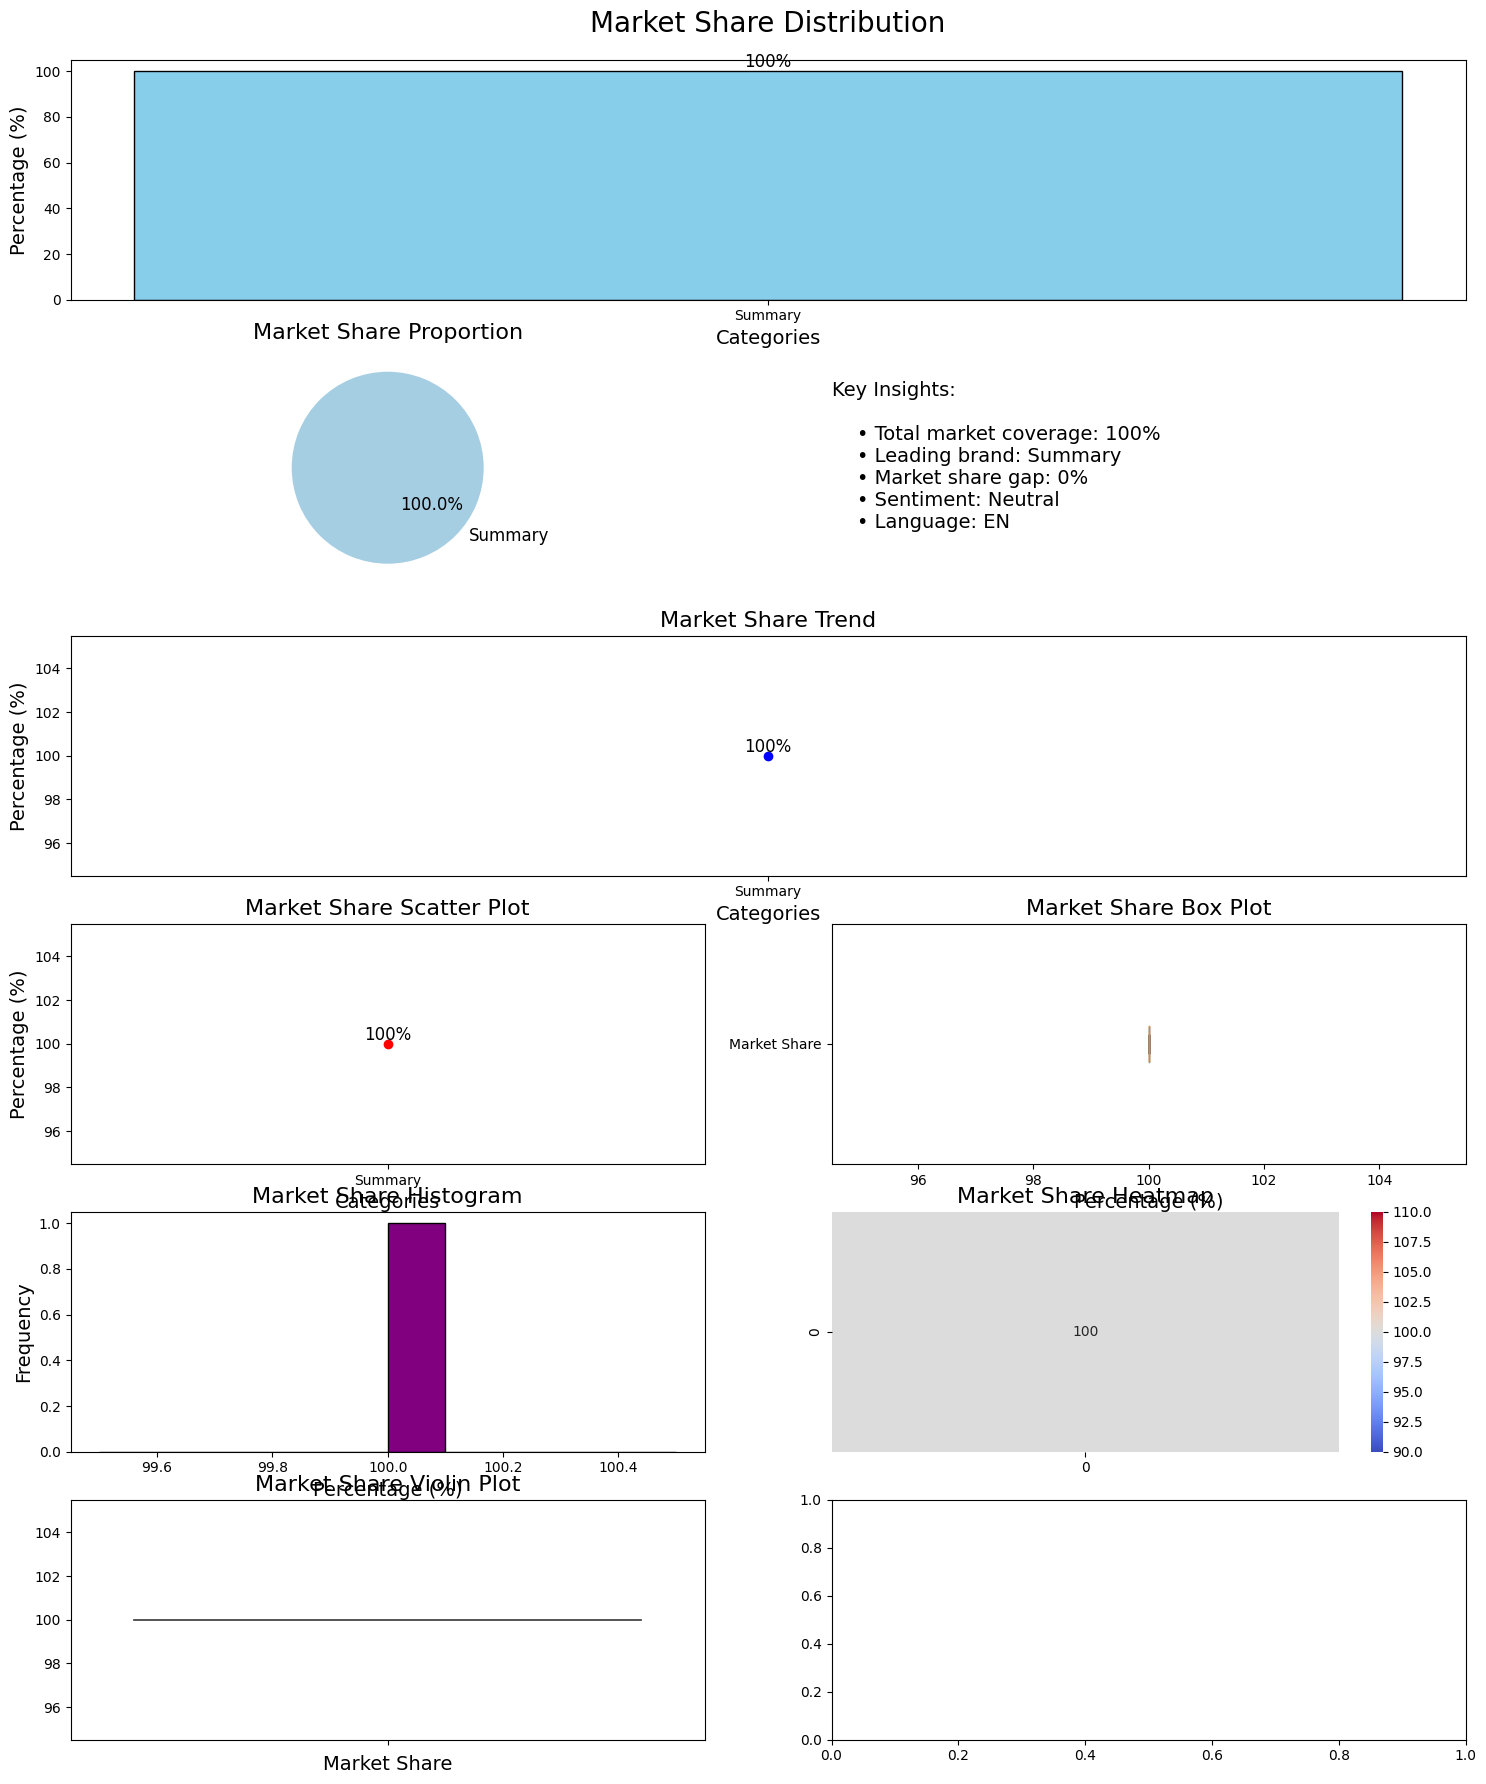

In [60]:
# Example usage
if __name__ == "__main__":
    file_path = 'D:\\1OOx-enginners-hackathon-submission-2\\data\\2015.csv'
    process_data_and_create_video(file_path)

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas import read_csv, read_excel
from scipy import stats
from moviepy.editor import VideoClip, concatenate_videoclips, VideoFileClip, AudioFileClip, ImageSequenceClip
from gtts import gTTS
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import os
import pickle
import requests
import time
import json
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForTokenClassification
import re
import shutil
from PIL import Image, ImageDraw, ImageFont
import imageio
import uuid

In [67]:
# Set the HF_HOME environment variable to change the cache path
os.environ['HF_HOME'] = "D:\\cahc_models_folder"  # Change this to your desired cache path

# Load the model and tokenizer from .pkl files
models_dir = os.path.abspath(os.path.join(os.getcwd(), 'models'))

with open(os.path.join(models_dir, 'model.pkl'), 'rb') as model_file:
    summary_model = pickle.load(model_file)

with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    summary_tokenizer = pickle.load(tokenizer_file)

In [74]:
def nlp_pipeline(text):
    # Prepare input
    input_text = f"summarize: {text}"
    inputs = summary_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Generate summary
    outputs = summary_model.generate(inputs, max_length=100)
    summary_text = summary_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract percentages and categories using regex patterns
    percentages = [int(x.strip('%')) for x in re.findall(r'\d+%', text)]
    words = text.split()
    categories = []

    # Find words after "use" or "uses"
    for i, word in enumerate(words):
        if word.lower() in ['use', 'uses'] and i + 1 < len(words):
            categories.append(words[i + 1])

    if not percentages or not categories:
        percentages = [100]
        categories = ['Summary']

    # Generate audio
    tts = gTTS(summary_text, lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)

    # return {
    #     'categories': categories,
    #     'values': percentages,
    #     'text': summary_text,
    #     'audio_path': audio_path
    # }
    # Sentiment analysis
    sentiment = TextBlob(summary_text).sentiment
    sentiment_label = 'positive' if sentiment.polarity >= 0.05 else 'negative' if sentiment.polarity <= -0.05 else 'neutral'

    # Text correction and language detection
    blob = TextBlob(summary_text)
    corrected_text = str(blob.correct())
    language = detect(corrected_text)

    # Generate audio
    tts = gTTS(corrected_text, lang='en')
    audio_filename = f'summary_audio_{uuid.uuid4().hex}.mp3'
    audio_path = os.path.join('D:\\1OOx-enginners-hackathon-submission-2\\uploads\\audio_files', audio_filename)
    tts.save(audio_path)

    return {
        'categories': categories,
        'values': percentages,
        'text': corrected_text,
        'audio_path': audio_path,
        'sentiment': sentiment_label,
        'language': language
    }

In [75]:
def create_detailed_infographic(summary):
    categories = summary['categories']
    values = summary['values']
    sentiment = summary.get('sentiment', 'neutral')
    language = summary.get('language', 'en')

    # Create figure with subplots
    fig = plt.figure(figsize=(18, 48))  # Increase the figure size to accommodate more subplots

    # Main bar plot
    ax1 = plt.subplot2grid((13, 2), (0, 0), colspan=2)  # Increase the grid size to (13, 2)
    bars = ax1.bar(categories, values, color='skyblue', edgecolor='black')
    ax1.set_title('Market Share Distribution', fontsize=20, pad=20)
    ax1.set_ylabel('Percentage (%)', fontsize=14)
    ax1.set_xlabel('Categories', fontsize=14)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{int(height)}%',
                 ha='center', va='bottom', fontsize=12, color='black')

    # Pie chart
    ax2 = plt.subplot2grid((13, 2), (1, 0))
    wedges, texts, autotexts = ax2.pie(values, labels=categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    for text in texts + autotexts:
        text.set_fontsize(12)
    ax2.set_title('Market Share Proportion', fontsize=16)

    # Additional insights text
    ax3 = plt.subplot2grid((13, 2), (1, 1))
    ax3.axis('off')
    total = sum(values)
    insights_text = f"""Key Insights:

    • Total market coverage: {total}%
    • Leading brand: {categories[values.index(max(values))]}
    • Market share gap: {max(values) - min(values)}%
    • Sentiment: {sentiment.capitalize()}
    • Language: {language.upper()}
    """
    ax3.text(0, 0.5, insights_text, fontsize=14, va='center', ha='left')

    # Line plot
    ax4 = plt.subplot2grid((13, 2), (2, 0), colspan=2)
    ax4.plot(categories, values, marker='o', linestyle='-', color='b')
    ax4.set_title('Market Share Trend', fontsize=16)
    ax4.set_ylabel('Percentage (%)', fontsize=14)
    ax4.set_xlabel('Categories', fontsize=14)
    for i, value in enumerate(values):
        ax4.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

    # Scatter plot
    ax5 = plt.subplot2grid((13, 2), (3, 0))
    ax5.scatter(categories, values, color='r')
    ax5.set_title('Market Share Scatter Plot', fontsize=16)
    ax5.set_ylabel('Percentage (%)', fontsize=14)
    ax5.set_xlabel('Categories', fontsize=14)
    for i, value in enumerate(values):
        ax5.text(i, value, f'{value}%', ha='center', va='bottom', fontsize=12, color='black')

    # Box plot
    ax6 = plt.subplot2grid((13, 2), (3, 1))
    ax6.boxplot(values, vert=False, patch_artist=True)
    ax6.set_title('Market Share Box Plot', fontsize=16)
    ax6.set_xlabel('Percentage (%)', fontsize=14)
    ax6.set_yticklabels(['Market Share'])

    # Histogram
    ax7 = plt.subplot2grid((13, 2), (4, 0))
    ax7.hist(values, bins=10, color='purple', edgecolor='black')
    ax7.set_title('Market Share Histogram', fontsize=16)
    ax7.set_xlabel('Percentage (%)', fontsize=14)
    ax7.set_ylabel('Frequency', fontsize=14)

    # Heatmap
    ax8 = plt.subplot2grid((13, 2), (4, 1))
    heatmap_data = np.array(values).reshape(-1, 1)
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='coolwarm', ax=ax8)
    ax8.set_title('Market Share Heatmap', fontsize=16)

    # Violin plot
    ax9 = plt.subplot2grid((13, 2), (5, 0))
    sns.violinplot(data=values, ax=ax9)
    ax9.set_title('Market Share Violin Plot', fontsize=16)
    ax9.set_xlabel('Market Share', fontsize=14)

    # Pair plot
    ax10 = plt.subplot2grid((13, 2), (5, 1))
    sns.pairplot(pd.DataFrame({'Categories': categories, 'Values': values}), ax=ax10)
    ax10.set_title('Market Share Pair Plot', fontsize=16)

    # KDE plot
    ax11 = plt.subplot2grid((13, 2), (6, 0))
    sns.kdeplot(values, ax=ax11, shade=True, color='green')
    ax11.set_title('Market Share KDE Plot', fontsize=16)
    ax11.set_xlabel('Percentage (%)', fontsize=14)

    # Joint plot
    ax12 = plt.subplot2grid((13, 2), (6, 1))
    sns.jointplot(x=categories, y=values, kind='scatter', ax=ax12)
    ax12.set_title('Market Share Joint Plot', fontsize=16)

    # Swarm plot
    ax13 = plt.subplot2grid((13, 2), (7, 0))
    sns.swarmplot(x=categories, y=values, ax=ax13)
    ax13.set_title('Market Share Swarm Plot', fontsize=16)
    ax13.set_xlabel('Categories', fontsize=14)
    ax13.set_ylabel('Percentage (%)', fontsize=14)

    # Strip plot
    ax14 = plt.subplot2grid((13, 2), (7, 1))
    sns.stripplot(x=categories, y=values, ax=ax14)
    ax14.set_title('Market Share Strip Plot', fontsize=16)
    ax14.set_xlabel('Categories', fontsize=14)
    ax14.set_ylabel('Percentage (%)', fontsize=14)

    # Rug plot
    ax15 = plt.subplot2grid((13, 2), (8, 0))
    sns.rugplot(values, ax=ax15)
    ax15.set_title('Market Share Rug Plot', fontsize=16)
    ax15.set_xlabel('Percentage (%)', fontsize=14)

    # Count plot
    ax16 = plt.subplot2grid((13, 2), (8, 1))
    sns.countplot(x=categories, ax=ax16)
    ax16.set_title('Market Share Count Plot', fontsize=16)
    ax16.set_xlabel('Categories', fontsize=14)
    ax16.set_ylabel('Count', fontsize=14)

    # Boxen plot
    ax17 = plt.subplot2grid((13, 2), (9, 0))
    sns.boxenplot(x=categories, y=values, ax=ax17)
    ax17.set_title('Market Share Boxen Plot', fontsize=16)
    ax17.set_xlabel('Categories', fontsize=14)
    ax17.set_ylabel('Percentage (%)', fontsize=14)

    # Point plot
    ax18 = plt.subplot2grid((13, 2), (9, 1))
    sns.pointplot(x=categories, y=values, ax=ax18)
    ax18.set_title('Market Share Point Plot', fontsize=16)
    ax18.set_xlabel('Categories', fontsize=14)
    ax18.set_ylabel('Percentage (%)', fontsize=14)

    # Residual plot
    ax19 = plt.subplot2grid((13, 2), (10, 0))
    sns.residplot(x=categories, y=values, ax=ax19)
    ax19.set_title('Market Share Residual Plot', fontsize=16)
    ax19.set_xlabel('Categories', fontsize=14)
    ax19.set_ylabel('Residuals', fontsize=14)

    # Lm plot
    ax20 = plt.subplot2grid((13, 2), (10, 1))
    sns.lmplot(x='Categories', y='Values', data=pd.DataFrame({'Categories': categories, 'Values': values}), ax=ax20)
    ax20.set_title('Market Share Lm Plot', fontsize=16)

    # PairGrid
    ax21 = plt.subplot2grid((13, 2), (11, 0))
    pairgrid = sns.PairGrid(pd.DataFrame({'Categories': categories, 'Values': values}))
    pairgrid.map(plt.scatter)
    ax21.set_title('Market Share PairGrid', fontsize=16)

    # FacetGrid
    ax22 = plt.subplot2grid((13, 2), (11, 1))
    facetgrid = sns.FacetGrid(pd.DataFrame({'Categories': categories, 'Values': values}), col='Categories')
    facetgrid.map(plt.hist, 'Values')
    ax22.set_title('Market Share FacetGrid', fontsize=16)

    # Heatmap with annotations
    ax23 = plt.subplot2grid((13, 2), (12, 0))
    sns.heatmap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm', ax=ax23)
    ax23.set_title('Market Share Heatmap with Annotations', fontsize=16)

    # Clustermap
    ax24 = plt.subplot2grid((13, 2), (12, 1))
    sns.clustermap(pd.DataFrame({'Categories': categories, 'Values': values}).corr(), annot=True, cmap='coolwarm')

    plt.tight_layout()

    # Save high-quality image
    output_path = 'detailed_infographic.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Detailed infographic saved as: {output_path}")
    return output_path

In [77]:
def create_animated_gif(summary):
    categories = summary['categories']
    values = summary['values']

    # Create a unique frames directory
    frames_dir = f'animation_frames_{uuid.uuid4().hex}'
    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)  # Remove directory if it exists
    os.makedirs(frames_dir)

    def create_frame(frame_number, value_multiplier, categories=categories, values=values):
        fig, ax = plt.subplots(figsize=(12, 7))

        # Calculate current height of bars
        current_values = [v * value_multiplier for v in values]

        # Create bars with current height
        bars = ax.bar(categories, current_values, color='skyblue')

        # Styling
        ax.set_title('Market Share Analysis', fontsize=20, pad=20)
        ax.set_xlabel('Brands', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.set_ylim(0, max(values) * 1.2)

        # Add value labels
        for bar, value in zip(bars, current_values):
            if value > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                       f'{int(value)}%',
                       ha='center', va='bottom', fontsize=12)

        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save frame
        frame_path = os.path.join(frames_dir, f'frame_{frame_number:03d}.png')
        plt.savefig(frame_path, dpi=300, bbox_inches='tight')
        plt.close()
        return frame_path

    # Generate frames
    frames = []
    num_frames = 20  # Number of frames for animation

    print("Generating frames...")
    for i in range(num_frames + 1):
        multiplier = i / num_frames
        frame_path = create_frame(i, multiplier)
        frames.append(frame_path)

    # Create GIF
    print("Creating GIF...")
    images = [Image.open(f) for f in frames]

    gif_path = 'animated_infographic.gif'
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=100,  # 100ms between frames
        loop=0
    )

    # Clean up frames directory
    try:
        shutil.rmtree(frames_dir)
        print("Cleanup completed successfully")
    except Exception as e:
        print(f"Cleanup error: {e}")

    print(f"Animation saved as GIF: {gif_path}")
    return gif_path

def convert_gif_to_storytelling_video(gif_path, summary):
    categories = summary['categories']
    values = summary['values']

    def create_text_frame(text, size=(1920, 1080), bg_color='white'):
        img = Image.new('RGB', size, color=bg_color)
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("arial.ttf", 60)
        except:
            font = ImageFont.load_default()

        # Get text bbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Center text
        x = (size[0] - text_width) // 2
        y = (size[1] - text_height) // 2

        draw.text((x, y), text, fill='black' if bg_color == 'white' else 'white', font=font)
        # Convert to RGB numpy array
        return np.array(img.convert('RGB'))

    # Prepare frames
    frames = []
    fps = 30

    # 1. Title sequence (2 seconds)
    title_frame = create_text_frame("Market Share Analysis", bg_color='black')
    for _ in range(2 * fps):
        frames.append(title_frame)

    # 2. GIF sequence (4 seconds)
    gif = Image.open(gif_path)
    gif_frames = []
    try:
        while True:
            frame = gif.copy()
            # Resize frame and ensure RGB
            frame = frame.convert('RGB').resize((1920, 1080), Image.LANCZOS)
            # Convert to numpy array
            frame_array = np.array(frame)
            gif_frames.append(frame_array)
            gif.seek(len(gif_frames))
    except EOFError:
        pass

    # Extend gif frames to 4 seconds
    frames_needed = 4 * fps
    while len(gif_frames) < frames_needed:
        gif_frames.extend(gif_frames)
    frames.extend(gif_frames[:frames_needed])

    # 3. Explanation sequence (4 seconds)
    explanations = [
        "Analyzing market share data...",
        f"Main competitor: {categories[values.index(max(values))]} leads with {max(values)}%",
        f"Market gap analysis shows {max(values) - min(values)}% difference",
        f"Total market coverage: {sum(values)}%",
        "Generating insights and recommendations..."
    ]

    frames_per_explanation = int((4 * fps) / len(explanations))
    for exp in explanations:
        exp_frame = create_text_frame(exp)
        for _ in range(frames_per_explanation):
            frames.append(exp_frame)

    # Verify all frames have the same shape and channels
    frame_shape = frames[0].shape
    frames = [frame.reshape(frame_shape) if frame.shape != frame_shape else frame
              for frame in frames]

    # Save as MP4
    output_path = 'data_storytelling_video.mp4'

    print("Writing video...")
    writer = imageio.get_writer(output_path, fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

    print(f"Data storytelling video saved as: {output_path}")

    # Add Narration Audio to Video
    final_video = "final_data_storytelling_video.mp4"
    add_auto_generated_audio_to_video(output_path, summary['audio_path'], output_video_path=final_video)

    return final_video

def add_auto_generated_audio_to_video(video_path, audio_file_path, output_video_path):
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip to the generated narration
    video_clip = video_clip.set_audio(audio_clip)

    # Write the final video with the audio
    video_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")
    def create_data_storytelling_video(csv_file_path, summary):
        # Load data from CSV
        data = pd.read_csv(csv_file_path)
        
        # Generate summary if not provided
        if not summary:
            summary = generate_summary(data)
        
        # Create animated GIF
        gif_path = create_animated_gif(summary)
        
        # Convert GIF to MP4
        mp4_gif_path = gif_path.replace('.gif', '.mp4')
        clip = VideoFileClip(gif_path)
        clip.write_videofile(mp4_gif_path, codec='libx264')
        
        # Create storytelling video
        storytelling_video_path = convert_gif_to_storytelling_video(mp4_gif_path, summary)
        
        return storytelling_video_path

    def generate_summary(data):
        # Example summary generation logic
        categories = data['Brand'].unique().tolist()
        values = data['Market Share'].tolist()
        text = "Market share analysis of various brands."
        audio_path = 'path_to_generated_audio.mp3'  # Placeholder for generated audio path
        
        summary = {
            'categories': categories,
            'values': values,
            'text': text,
            'audio_path': audio_path,
            'sentiment': 'neutral',
            'language': 'en'
        }
        
        return summary

In [79]:
# Example usage
storytelling_video_path = create_data_storytelling_video(csv_file_path, summary)
print(f"Data storytelling video created at: {storytelling_video_path}")

NameError: name 'create_data_storytelling_video' is not defined

In [71]:
def create_infographic_video(user_prompt):
    final_video_path = generate_infographics_from_prompt(user_prompt)
    print(f"Infographic video created successfully: {final_video_path}")

def process_data_and_create_video(file_path):
    # Determine file type and read the data
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format")

    # Convert the DataFrame to a string prompt
    prompt = df.to_string(index=False)

    # Create the infographic video
    create_infographic_video(prompt)

In [73]:
# Example usage
if __name__ == "__main__":
    file_path = 'D:\\1OOx-enginners-hackathon-submission-2\\data\\2015.csv'
    process_data_and_create_video(file_path)

Detailed infographic saved as: detailed_infographic.png
Generating frames...
Creating GIF...
Cleanup completed successfully
Animation saved as GIF: animated_infographic.gif


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Writing video...
Data storytelling video saved as: data_storytelling_video.mp4
Moviepy - Building video final_data_storytelling_video.mp4.
MoviePy - Writing audio in final_data_storytelling_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video final_data_storytelling_video.mp4



Moviepy - Done !
Moviepy - video ready final_data_storytelling_video.mp4
Infographic video created successfully: final_data_storytelling_video.mp4
